First of all the standard packages will be installed and we check which version of the CLMM code is currently installed

In [1]:
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import matplotlib.pyplot as plt
import numpy as np
import astropy
from astropy import units
import clmm.dataops as da
import clmm.galaxycluster as gc
import clmm.theory as theory
from clmm import Cosmology
from clmm import support
from clmm.support import mock_data as mock
from clmm.support import sampler
from clmm.support.sampler import *
from clmm.support.sampler import fitters
import random
from scipy.interpolate import interp1d

plt.rcParams['font.family']=['gothambook','gotham','gotham-book','serif']

clmm.__version__


'0.9.3'

Since we are working with the random modul we use random seed in the next step for reproducibility.


In [2]:
np.random.seed(22)

To create mock data, we need to define a true cosmology, which is currently done with astropy's cosmology library.

In [3]:
cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)


We now set some parameters for a mock galaxy cluster:
    cluster_data[k][0] = cluster_m
    cluster_data[k][1] = concentration
    cluster_data[k][2] = cluster_ra
    cluster_data[k][3] = cluster_dec
    cluster_data[k][4] = cluster_z
    cluster_data[k][5] = ngals
    cluster_data[k][6] = logm
    cluster_data[k][7] = number density 
and print the array

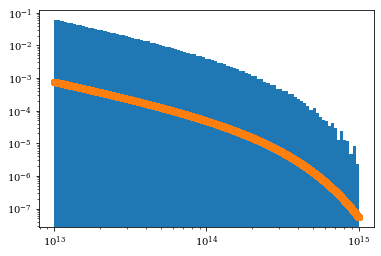

In [4]:
#could be function

lower_limit =13
upper_limit =15
nbinhist=100
norm = (upper_limit-lower_limit)/nbinhist

M_star = 2.e14
b=4*10**(-5)
numsamp= 10**6 #input
numstep = 10**4

#define x range 1e12-1e15 in num steps
x = np.logspace(lower_limit,upper_limit,numstep)
#define y values from the function 
y = (b*(1/(x/M_star))*np.exp(-(x)/M_star))

#calculate cumulative sum of the y values (numpy)
y_cm = np.cumsum(y)
y_cm = y_cm-min(y_cm)
y_cm = y_cm/np.max(y_cm)

#invert x and y variables (flipping)and interpolate that function 
f = interp1d(y_cm,x , fill_value=(0,1))
#Generate N random numbers uniformly between 0 & 1: u_i~U(0,1)
ynew = np.random.random(numsamp)
#Using the Inverse of the CDF and the values u_i, compute x_i = F^-1(u_i)
x_samp = f(ynew) #return

#plot it to see the result
plt.hist(x_samp, bins=np.logspace(lower_limit,upper_limit,nbinhist),weights=np.repeat(numsamp/sum(y*x),numsamp)/norm)
plt.yscale('log')
plt.xscale('log')
plt.plot(x, y, 'o')
#plt.show()


#use that interpolated function to predict num samples



In [5]:
np.set_printoptions(precision=3)   
num = 100
cluster_data = np.zeros((num,7))
#m_star=1.8.e14
for k in range(num):#replace with vector
   #cluster_data[k][7] = np.random.randint(1.e(-8),1.e(-2))    
    cluster_data[k][0] = x_samp[k] #masse direkt aus der funktion machen
    cluster_data[k][6] = np.log(cluster_data[k][0])/np.log(10)#logm
    cluster_data[k][2] = 0#ra
    cluster_data[k][3] = 0#dec
    cluster_data[k][4] = np.random.uniform(0.1,0.6)#redshift
    cluster_data[k][1] = 5.72/((1+cluster_data[k][4])**0.71)*(cluster_data[k][0]/10.e14)**(-0.081)#consentration
    cluster_data[k][5] = np.random.randint(50,10000)#ngals


In [6]:

ideal_data = []
noisy_data = []

for k in range(num):
    buggy_data = mock.generate_galaxy_catalog(cluster_data[k][0], 
                                              cluster_data[k][4], 
                                              cluster_data[k][1], 
                                                           cosmo, 
                                                       'chang13', 
                             zsrc_min = cluster_data[k][4] + 0.1,
                                                 shapenoise=0.05, 
                                      photoz_sigma_unscaled=0.05, 
                                    ngals=int(cluster_data[k][5])) 
   
    #sortiert nachher die galaxien raus die den falschen redshift besitzen
    mask = buggy_data['z'] < cluster_data[k][4] 
    #die galaxien sollten entfernt werden nicht maskiert...nur vorrübergehend
   
    buggy_data['z'] = np.where(buggy_data['z'] < cluster_data[k][4], 
                               np.random.uniform(cluster_data[k][4],
                                            cluster_data[k][4]+0.1), 
                                                    buggy_data['z'])
    
    mask = buggy_data['z'] < cluster_data[k][4]
    realredshift = buggy_data['z']
    #print(sum(buggy_data['z']<=cluster_data[k][4]))
    
    ideal_data.append(mock.generate_galaxy_catalog(cluster_data[k][0],
                                                   cluster_data[k][4], 
                                                   cluster_data[k][1],
                                                                cosmo,
                                                            'chang13',
                                  zsrc_min = cluster_data[k][4] + 0.1, 
                                     ngals = int(cluster_data[k][5]))) 
    noisy_data.append(buggy_data)


    

/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_l

/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_l

/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/clmm-0.9.3-py3.9.egg/clmm/theory/func_l

In [7]:
print((ideal_data[0][:]))

self.__class__.__name__
> defined by:cosmo=None
> with columns: ra, dec, e1, e2, z, ztrue, id


Now we compete the radius which we will need later on

In [8]:

radius = []
for k in range(num):
    variable = clmm.dataops._compute_lensing_angles_astropy(cluster_data[k][2], 
                                                            cluster_data[k][3], 
                                                            ideal_data[k]['ra'], 
                                                            ideal_data[k]['dec'])
    radius.append(variable) 
    
    print(radius)
    #numpy arrays instead(cluster_data macht das so) inline for loop

[(array([0.007, 0.008, 0.005, ..., 0.006, 0.005, 0.007]), array([-1.377, -2.605, -0.506, ...,  1.585,  1.289, -2.585]))]
[(array([0.007, 0.008, 0.005, ..., 0.006, 0.005, 0.007]), array([-1.377, -2.605, -0.506, ...,  1.585,  1.289, -2.585])), (array([0.003, 0.004, 0.001, ..., 0.005, 0.007, 0.004]), array([ 2.153, -1.681, -2.15 , ..., -1.237,  2.337, -0.764]))]
[(array([0.007, 0.008, 0.005, ..., 0.006, 0.005, 0.007]), array([-1.377, -2.605, -0.506, ...,  1.585,  1.289, -2.585])), (array([0.003, 0.004, 0.001, ..., 0.005, 0.007, 0.004]), array([ 2.153, -1.681, -2.15 , ..., -1.237,  2.337, -0.764])), (array([0.002, 0.002, 0.006, ..., 0.001, 0.005, 0.002]), array([-3.096, -0.843,  2.534, ..., -2.406,  2.516,  0.054]))]
[(array([0.007, 0.008, 0.005, ..., 0.006, 0.005, 0.007]), array([-1.377, -2.605, -0.506, ...,  1.585,  1.289, -2.585])), (array([0.003, 0.004, 0.001, ..., 0.005, 0.007, 0.004]), array([ 2.153, -1.681, -2.15 , ..., -1.237,  2.337, -0.764])), (array([0.002, 0.002, 0.006, ..., 0.

[(array([0.007, 0.008, 0.005, ..., 0.006, 0.005, 0.007]), array([-1.377, -2.605, -0.506, ...,  1.585,  1.289, -2.585])), (array([0.003, 0.004, 0.001, ..., 0.005, 0.007, 0.004]), array([ 2.153, -1.681, -2.15 , ..., -1.237,  2.337, -0.764])), (array([0.002, 0.002, 0.006, ..., 0.001, 0.005, 0.002]), array([-3.096, -0.843,  2.534, ..., -2.406,  2.516,  0.054])), (array([0.001, 0.002, 0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.003,
       0.002, 0.001, 0.003, 0.003, 0.001, 0.003, 0.004, 0.002, 0.002,
       0.002, 0.002, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.003, 0.002, 0.003, 0.002, 0.001, 0.003, 0.   , 0.003, 0.002,
       0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.002, 0.003, 0.002, 0.003, 0.002, 0.003, 0.003, 0.002, 0.003,
       0.003, 0.003, 0.002, 0.001, 0.001, 0.003, 0.001, 0.003, 0.001,
       0.001, 0.004, 0.001, 0.001, 0.002, 0.001, 0.003, 0.001, 0.003,
       0.003, 0.003, 0.001, 0.003, 0.   , 0.001, 0.003, 0.002, 0.004,
       0

[(array([0.007, 0.008, 0.005, ..., 0.006, 0.005, 0.007]), array([-1.377, -2.605, -0.506, ...,  1.585,  1.289, -2.585])), (array([0.003, 0.004, 0.001, ..., 0.005, 0.007, 0.004]), array([ 2.153, -1.681, -2.15 , ..., -1.237,  2.337, -0.764])), (array([0.002, 0.002, 0.006, ..., 0.001, 0.005, 0.002]), array([-3.096, -0.843,  2.534, ..., -2.406,  2.516,  0.054])), (array([0.001, 0.002, 0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.003,
       0.002, 0.001, 0.003, 0.003, 0.001, 0.003, 0.004, 0.002, 0.002,
       0.002, 0.002, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.003, 0.002, 0.003, 0.002, 0.001, 0.003, 0.   , 0.003, 0.002,
       0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.002, 0.003, 0.002, 0.003, 0.002, 0.003, 0.003, 0.002, 0.003,
       0.003, 0.003, 0.002, 0.001, 0.001, 0.003, 0.001, 0.003, 0.001,
       0.001, 0.004, 0.001, 0.001, 0.002, 0.001, 0.003, 0.001, 0.003,
       0.003, 0.003, 0.001, 0.003, 0.   , 0.001, 0.003, 0.002, 0.004,
       0

[(array([0.007, 0.008, 0.005, ..., 0.006, 0.005, 0.007]), array([-1.377, -2.605, -0.506, ...,  1.585,  1.289, -2.585])), (array([0.003, 0.004, 0.001, ..., 0.005, 0.007, 0.004]), array([ 2.153, -1.681, -2.15 , ..., -1.237,  2.337, -0.764])), (array([0.002, 0.002, 0.006, ..., 0.001, 0.005, 0.002]), array([-3.096, -0.843,  2.534, ..., -2.406,  2.516,  0.054])), (array([0.001, 0.002, 0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.003,
       0.002, 0.001, 0.003, 0.003, 0.001, 0.003, 0.004, 0.002, 0.002,
       0.002, 0.002, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.003, 0.002, 0.003, 0.002, 0.001, 0.003, 0.   , 0.003, 0.002,
       0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.002, 0.003, 0.002, 0.003, 0.002, 0.003, 0.003, 0.002, 0.003,
       0.003, 0.003, 0.002, 0.001, 0.001, 0.003, 0.001, 0.003, 0.001,
       0.001, 0.004, 0.001, 0.001, 0.002, 0.001, 0.003, 0.001, 0.003,
       0.003, 0.003, 0.001, 0.003, 0.   , 0.001, 0.003, 0.002, 0.004,
       0

[(array([0.007, 0.008, 0.005, ..., 0.006, 0.005, 0.007]), array([-1.377, -2.605, -0.506, ...,  1.585,  1.289, -2.585])), (array([0.003, 0.004, 0.001, ..., 0.005, 0.007, 0.004]), array([ 2.153, -1.681, -2.15 , ..., -1.237,  2.337, -0.764])), (array([0.002, 0.002, 0.006, ..., 0.001, 0.005, 0.002]), array([-3.096, -0.843,  2.534, ..., -2.406,  2.516,  0.054])), (array([0.001, 0.002, 0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.003,
       0.002, 0.001, 0.003, 0.003, 0.001, 0.003, 0.004, 0.002, 0.002,
       0.002, 0.002, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.003, 0.002, 0.003, 0.002, 0.001, 0.003, 0.   , 0.003, 0.002,
       0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.002, 0.003, 0.002, 0.003, 0.002, 0.003, 0.003, 0.002, 0.003,
       0.003, 0.003, 0.002, 0.001, 0.001, 0.003, 0.001, 0.003, 0.001,
       0.001, 0.004, 0.001, 0.001, 0.002, 0.001, 0.003, 0.001, 0.003,
       0.003, 0.003, 0.001, 0.003, 0.   , 0.001, 0.003, 0.002, 0.004,
       0

[(array([0.007, 0.008, 0.005, ..., 0.006, 0.005, 0.007]), array([-1.377, -2.605, -0.506, ...,  1.585,  1.289, -2.585])), (array([0.003, 0.004, 0.001, ..., 0.005, 0.007, 0.004]), array([ 2.153, -1.681, -2.15 , ..., -1.237,  2.337, -0.764])), (array([0.002, 0.002, 0.006, ..., 0.001, 0.005, 0.002]), array([-3.096, -0.843,  2.534, ..., -2.406,  2.516,  0.054])), (array([0.001, 0.002, 0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.003,
       0.002, 0.001, 0.003, 0.003, 0.001, 0.003, 0.004, 0.002, 0.002,
       0.002, 0.002, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.003, 0.002, 0.003, 0.002, 0.001, 0.003, 0.   , 0.003, 0.002,
       0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.002, 0.003, 0.002, 0.003, 0.002, 0.003, 0.003, 0.002, 0.003,
       0.003, 0.003, 0.002, 0.001, 0.001, 0.003, 0.001, 0.003, 0.001,
       0.001, 0.004, 0.001, 0.001, 0.002, 0.001, 0.003, 0.001, 0.003,
       0.003, 0.003, 0.001, 0.003, 0.   , 0.001, 0.003, 0.002, 0.004,
       0

[(array([0.007, 0.008, 0.005, ..., 0.006, 0.005, 0.007]), array([-1.377, -2.605, -0.506, ...,  1.585,  1.289, -2.585])), (array([0.003, 0.004, 0.001, ..., 0.005, 0.007, 0.004]), array([ 2.153, -1.681, -2.15 , ..., -1.237,  2.337, -0.764])), (array([0.002, 0.002, 0.006, ..., 0.001, 0.005, 0.002]), array([-3.096, -0.843,  2.534, ..., -2.406,  2.516,  0.054])), (array([0.001, 0.002, 0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.003,
       0.002, 0.001, 0.003, 0.003, 0.001, 0.003, 0.004, 0.002, 0.002,
       0.002, 0.002, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.003, 0.002, 0.003, 0.002, 0.001, 0.003, 0.   , 0.003, 0.002,
       0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.002, 0.003, 0.002, 0.003, 0.002, 0.003, 0.003, 0.002, 0.003,
       0.003, 0.003, 0.002, 0.001, 0.001, 0.003, 0.001, 0.003, 0.001,
       0.001, 0.004, 0.001, 0.001, 0.002, 0.001, 0.003, 0.001, 0.003,
       0.003, 0.003, 0.001, 0.003, 0.   , 0.001, 0.003, 0.002, 0.004,
       0

        0.159,  2.702,  2.448,  1.738,  1.657,  1.901, -1.985, -2.986]))]
[(array([0.007, 0.008, 0.005, ..., 0.006, 0.005, 0.007]), array([-1.377, -2.605, -0.506, ...,  1.585,  1.289, -2.585])), (array([0.003, 0.004, 0.001, ..., 0.005, 0.007, 0.004]), array([ 2.153, -1.681, -2.15 , ..., -1.237,  2.337, -0.764])), (array([0.002, 0.002, 0.006, ..., 0.001, 0.005, 0.002]), array([-3.096, -0.843,  2.534, ..., -2.406,  2.516,  0.054])), (array([0.001, 0.002, 0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.003,
       0.002, 0.001, 0.003, 0.003, 0.001, 0.003, 0.004, 0.002, 0.002,
       0.002, 0.002, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.003, 0.002, 0.003, 0.002, 0.001, 0.003, 0.   , 0.003, 0.002,
       0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.002, 0.003, 0.002, 0.003, 0.002, 0.003, 0.003, 0.002, 0.003,
       0.003, 0.003, 0.002, 0.001, 0.001, 0.003, 0.001, 0.003, 0.001,
       0.001, 0.004, 0.001, 0.001, 0.002, 0.001, 0.003, 0.001, 0.003,
    

[(array([0.007, 0.008, 0.005, ..., 0.006, 0.005, 0.007]), array([-1.377, -2.605, -0.506, ...,  1.585,  1.289, -2.585])), (array([0.003, 0.004, 0.001, ..., 0.005, 0.007, 0.004]), array([ 2.153, -1.681, -2.15 , ..., -1.237,  2.337, -0.764])), (array([0.002, 0.002, 0.006, ..., 0.001, 0.005, 0.002]), array([-3.096, -0.843,  2.534, ..., -2.406,  2.516,  0.054])), (array([0.001, 0.002, 0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.003,
       0.002, 0.001, 0.003, 0.003, 0.001, 0.003, 0.004, 0.002, 0.002,
       0.002, 0.002, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.003, 0.002, 0.003, 0.002, 0.001, 0.003, 0.   , 0.003, 0.002,
       0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.002, 0.003, 0.002, 0.003, 0.002, 0.003, 0.003, 0.002, 0.003,
       0.003, 0.003, 0.002, 0.001, 0.001, 0.003, 0.001, 0.003, 0.001,
       0.001, 0.004, 0.001, 0.001, 0.002, 0.001, 0.003, 0.001, 0.003,
       0.003, 0.003, 0.001, 0.003, 0.   , 0.001, 0.003, 0.002, 0.004,
       0

[(array([0.007, 0.008, 0.005, ..., 0.006, 0.005, 0.007]), array([-1.377, -2.605, -0.506, ...,  1.585,  1.289, -2.585])), (array([0.003, 0.004, 0.001, ..., 0.005, 0.007, 0.004]), array([ 2.153, -1.681, -2.15 , ..., -1.237,  2.337, -0.764])), (array([0.002, 0.002, 0.006, ..., 0.001, 0.005, 0.002]), array([-3.096, -0.843,  2.534, ..., -2.406,  2.516,  0.054])), (array([0.001, 0.002, 0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.003,
       0.002, 0.001, 0.003, 0.003, 0.001, 0.003, 0.004, 0.002, 0.002,
       0.002, 0.002, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.003, 0.002, 0.003, 0.002, 0.001, 0.003, 0.   , 0.003, 0.002,
       0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.002, 0.003, 0.002, 0.003, 0.002, 0.003, 0.003, 0.002, 0.003,
       0.003, 0.003, 0.002, 0.001, 0.001, 0.003, 0.001, 0.003, 0.001,
       0.001, 0.004, 0.001, 0.001, 0.002, 0.001, 0.003, 0.001, 0.003,
       0.003, 0.003, 0.001, 0.003, 0.   , 0.001, 0.003, 0.002, 0.004,
       0

[(array([0.007, 0.008, 0.005, ..., 0.006, 0.005, 0.007]), array([-1.377, -2.605, -0.506, ...,  1.585,  1.289, -2.585])), (array([0.003, 0.004, 0.001, ..., 0.005, 0.007, 0.004]), array([ 2.153, -1.681, -2.15 , ..., -1.237,  2.337, -0.764])), (array([0.002, 0.002, 0.006, ..., 0.001, 0.005, 0.002]), array([-3.096, -0.843,  2.534, ..., -2.406,  2.516,  0.054])), (array([0.001, 0.002, 0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.003,
       0.002, 0.001, 0.003, 0.003, 0.001, 0.003, 0.004, 0.002, 0.002,
       0.002, 0.002, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.003, 0.002, 0.003, 0.002, 0.001, 0.003, 0.   , 0.003, 0.002,
       0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.002, 0.003, 0.002, 0.003, 0.002, 0.003, 0.003, 0.002, 0.003,
       0.003, 0.003, 0.002, 0.001, 0.001, 0.003, 0.001, 0.003, 0.001,
       0.001, 0.004, 0.001, 0.001, 0.002, 0.001, 0.003, 0.001, 0.003,
       0.003, 0.003, 0.001, 0.003, 0.   , 0.001, 0.003, 0.002, 0.004,
       0

[(array([0.007, 0.008, 0.005, ..., 0.006, 0.005, 0.007]), array([-1.377, -2.605, -0.506, ...,  1.585,  1.289, -2.585])), (array([0.003, 0.004, 0.001, ..., 0.005, 0.007, 0.004]), array([ 2.153, -1.681, -2.15 , ..., -1.237,  2.337, -0.764])), (array([0.002, 0.002, 0.006, ..., 0.001, 0.005, 0.002]), array([-3.096, -0.843,  2.534, ..., -2.406,  2.516,  0.054])), (array([0.001, 0.002, 0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.003,
       0.002, 0.001, 0.003, 0.003, 0.001, 0.003, 0.004, 0.002, 0.002,
       0.002, 0.002, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.003, 0.002, 0.003, 0.002, 0.001, 0.003, 0.   , 0.003, 0.002,
       0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.002, 0.003, 0.002, 0.003, 0.002, 0.003, 0.003, 0.002, 0.003,
       0.003, 0.003, 0.002, 0.001, 0.001, 0.003, 0.001, 0.003, 0.001,
       0.001, 0.004, 0.001, 0.001, 0.002, 0.001, 0.003, 0.001, 0.003,
       0.003, 0.003, 0.001, 0.003, 0.   , 0.001, 0.003, 0.002, 0.004,
       0

[(array([0.007, 0.008, 0.005, ..., 0.006, 0.005, 0.007]), array([-1.377, -2.605, -0.506, ...,  1.585,  1.289, -2.585])), (array([0.003, 0.004, 0.001, ..., 0.005, 0.007, 0.004]), array([ 2.153, -1.681, -2.15 , ..., -1.237,  2.337, -0.764])), (array([0.002, 0.002, 0.006, ..., 0.001, 0.005, 0.002]), array([-3.096, -0.843,  2.534, ..., -2.406,  2.516,  0.054])), (array([0.001, 0.002, 0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.003,
       0.002, 0.001, 0.003, 0.003, 0.001, 0.003, 0.004, 0.002, 0.002,
       0.002, 0.002, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.003, 0.002, 0.003, 0.002, 0.001, 0.003, 0.   , 0.003, 0.002,
       0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.002, 0.003, 0.002, 0.003, 0.002, 0.003, 0.003, 0.002, 0.003,
       0.003, 0.003, 0.002, 0.001, 0.001, 0.003, 0.001, 0.003, 0.001,
       0.001, 0.004, 0.001, 0.001, 0.002, 0.001, 0.003, 0.001, 0.003,
       0.003, 0.003, 0.001, 0.003, 0.   , 0.001, 0.003, 0.002, 0.004,
       0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[(array([0.007, 0.008, 0.005, ..., 0.006, 0.005, 0.007]), array([-1.377, -2.605, -0.506, ...,  1.585,  1.289, -2.585])), (array([0.003, 0.004, 0.001, ..., 0.005, 0.007, 0.004]), array([ 2.153, -1.681, -2.15 , ..., -1.237,  2.337, -0.764])), (array([0.002, 0.002, 0.006, ..., 0.001, 0.005, 0.002]), array([-3.096, -0.843,  2.534, ..., -2.406,  2.516,  0.054])), (array([0.001, 0.002, 0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.003,
       0.002, 0.001, 0.003, 0.003, 0.001, 0.003, 0.004, 0.002, 0.002,
       0.002, 0.002, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.003, 0.002, 0.003, 0.002, 0.001, 0.003, 0.   , 0.003, 0.002,
       0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.002, 0.003, 0.002, 0.003, 0.002, 0.003, 0.003, 0.002, 0.003,
       0.003, 0.003, 0.002, 0.001, 0.001, 0.003, 0.001, 0.003, 0.001,
       0.001, 0.004, 0.001, 0.001, 0.002, 0.001, 0.003, 0.001, 0.003,
       0.003, 0.003, 0.001, 0.003, 0.   , 0.001, 0.003, 0.002, 0.004,
       0

[(array([0.007, 0.008, 0.005, ..., 0.006, 0.005, 0.007]), array([-1.377, -2.605, -0.506, ...,  1.585,  1.289, -2.585])), (array([0.003, 0.004, 0.001, ..., 0.005, 0.007, 0.004]), array([ 2.153, -1.681, -2.15 , ..., -1.237,  2.337, -0.764])), (array([0.002, 0.002, 0.006, ..., 0.001, 0.005, 0.002]), array([-3.096, -0.843,  2.534, ..., -2.406,  2.516,  0.054])), (array([0.001, 0.002, 0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.003,
       0.002, 0.001, 0.003, 0.003, 0.001, 0.003, 0.004, 0.002, 0.002,
       0.002, 0.002, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.003, 0.002, 0.003, 0.002, 0.001, 0.003, 0.   , 0.003, 0.002,
       0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.002, 0.003, 0.002, 0.003, 0.002, 0.003, 0.003, 0.002, 0.003,
       0.003, 0.003, 0.002, 0.001, 0.001, 0.003, 0.001, 0.003, 0.001,
       0.001, 0.004, 0.001, 0.001, 0.002, 0.001, 0.003, 0.001, 0.003,
       0.003, 0.003, 0.001, 0.003, 0.   , 0.001, 0.003, 0.002, 0.004,
       0

[(array([0.007, 0.008, 0.005, ..., 0.006, 0.005, 0.007]), array([-1.377, -2.605, -0.506, ...,  1.585,  1.289, -2.585])), (array([0.003, 0.004, 0.001, ..., 0.005, 0.007, 0.004]), array([ 2.153, -1.681, -2.15 , ..., -1.237,  2.337, -0.764])), (array([0.002, 0.002, 0.006, ..., 0.001, 0.005, 0.002]), array([-3.096, -0.843,  2.534, ..., -2.406,  2.516,  0.054])), (array([0.001, 0.002, 0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.003,
       0.002, 0.001, 0.003, 0.003, 0.001, 0.003, 0.004, 0.002, 0.002,
       0.002, 0.002, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.003, 0.002, 0.003, 0.002, 0.001, 0.003, 0.   , 0.003, 0.002,
       0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.002, 0.003, 0.002, 0.003, 0.002, 0.003, 0.003, 0.002, 0.003,
       0.003, 0.003, 0.002, 0.001, 0.001, 0.003, 0.001, 0.003, 0.001,
       0.001, 0.004, 0.001, 0.001, 0.002, 0.001, 0.003, 0.001, 0.003,
       0.003, 0.003, 0.001, 0.003, 0.   , 0.001, 0.003, 0.002, 0.004,
       0

[(array([0.007, 0.008, 0.005, ..., 0.006, 0.005, 0.007]), array([-1.377, -2.605, -0.506, ...,  1.585,  1.289, -2.585])), (array([0.003, 0.004, 0.001, ..., 0.005, 0.007, 0.004]), array([ 2.153, -1.681, -2.15 , ..., -1.237,  2.337, -0.764])), (array([0.002, 0.002, 0.006, ..., 0.001, 0.005, 0.002]), array([-3.096, -0.843,  2.534, ..., -2.406,  2.516,  0.054])), (array([0.001, 0.002, 0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.003,
       0.002, 0.001, 0.003, 0.003, 0.001, 0.003, 0.004, 0.002, 0.002,
       0.002, 0.002, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.003, 0.002, 0.003, 0.002, 0.001, 0.003, 0.   , 0.003, 0.002,
       0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.002, 0.003, 0.002, 0.003, 0.002, 0.003, 0.003, 0.002, 0.003,
       0.003, 0.003, 0.002, 0.001, 0.001, 0.003, 0.001, 0.003, 0.001,
       0.001, 0.004, 0.001, 0.001, 0.002, 0.001, 0.003, 0.001, 0.003,
       0.003, 0.003, 0.001, 0.003, 0.   , 0.001, 0.003, 0.002, 0.004,
       0

[(array([0.007, 0.008, 0.005, ..., 0.006, 0.005, 0.007]), array([-1.377, -2.605, -0.506, ...,  1.585,  1.289, -2.585])), (array([0.003, 0.004, 0.001, ..., 0.005, 0.007, 0.004]), array([ 2.153, -1.681, -2.15 , ..., -1.237,  2.337, -0.764])), (array([0.002, 0.002, 0.006, ..., 0.001, 0.005, 0.002]), array([-3.096, -0.843,  2.534, ..., -2.406,  2.516,  0.054])), (array([0.001, 0.002, 0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.003,
       0.002, 0.001, 0.003, 0.003, 0.001, 0.003, 0.004, 0.002, 0.002,
       0.002, 0.002, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.003, 0.002, 0.003, 0.002, 0.001, 0.003, 0.   , 0.003, 0.002,
       0.003, 0.003, 0.003, 0.001, 0.004, 0.002, 0.001, 0.002, 0.003,
       0.002, 0.003, 0.002, 0.003, 0.002, 0.003, 0.003, 0.002, 0.003,
       0.003, 0.003, 0.002, 0.001, 0.001, 0.003, 0.001, 0.003, 0.001,
       0.001, 0.004, 0.001, 0.001, 0.002, 0.001, 0.003, 0.001, 0.003,
       0.003, 0.003, 0.001, 0.003, 0.   , 0.001, 0.003, 0.002, 0.004,
       0

The galaxy catalogs are converted to a clmm.GalaxyCluster object and may be saved for later use.


In [9]:
gc_object =[]
for k in range(num):

    cluster_id = "CL_ideal"
    gc_object.append( clmm.GalaxyCluster(cluster_id, 
                                 cluster_data[k][2],
                                 cluster_data[k][3],
                                 cluster_data[k][4], 
                                     ideal_data[k]))
    gc_object[k].save('ideal_GC_'+str(k)+'.pkl')

gc_object =[]

for k in range(num):

    cluster_id = "CL_noisy"
    gc_object.append( clmm.GalaxyCluster(cluster_id,
                                 cluster_data[k][2],
                                 cluster_data[k][3],
                                 cluster_data[k][4], 
                                     noisy_data[k]))
    gc_object[k].save('noisy_GC_'+str(k)+'.pkl')


In [10]:
print(gc_object)

[GalaxyCluster CL_noisy: (ra=0.0, dec=0.0) at z=0.16156920601514627
> 9734 source galaxies
> With columns: ra dec e1 e2 z ztrue pzbins pzpdf id, GalaxyCluster CL_noisy: (ra=0.0, dec=0.0) at z=0.2448760301574456
> 6318 source galaxies
> With columns: ra dec e1 e2 z ztrue pzbins pzpdf id, GalaxyCluster CL_noisy: (ra=0.0, dec=0.0) at z=0.2495522268329927
> 3653 source galaxies
> With columns: ra dec e1 e2 z ztrue pzbins pzpdf id, GalaxyCluster CL_noisy: (ra=0.0, dec=0.0) at z=0.5630186423838484
> 912 source galaxies
> With columns: ra dec e1 e2 z ztrue pzbins pzpdf id, GalaxyCluster CL_noisy: (ra=0.0, dec=0.0) at z=0.36977607992350947
> 7194 source galaxies
> With columns: ra dec e1 e2 z ztrue pzbins pzpdf id, GalaxyCluster CL_noisy: (ra=0.0, dec=0.0) at z=0.4612751084239243
> 9156 source galaxies
> With columns: ra dec e1 e2 z ztrue pzbins pzpdf id, GalaxyCluster CL_noisy: (ra=0.0, dec=0.0) at z=0.5464665274862581
> 8347 source galaxies
> With columns: ra dec e1 e2 z ztrue pzbins pzpdf i

Any saved clmm.GalaxyCluster object may be read in for analysis.

In [11]:
cl_ideal = []
cl_noisy = []
for k in range(num):
    cl_ideal.append (clmm.GalaxyCluster.load('ideal_GC_'+str(k)+'.pkl'))
    cl_noisy.append (clmm.GalaxyCluster.load('noisy_GC_'+str(k)+'.pkl'))

Redshift of galaxies generated by mock data are distributed following the Chang. (2013) redshift distribution.

Deriving observables

Computing shear

clmm.GalaxyCluster.compute_tangential_and_cross_components calculates the tangential and cross shears for each source galaxy in the cluster.

In [12]:
for k in range(num):
    cl_ideal[k].compute_tangential_and_cross_components(geometry="flat")
    cl_noisy[k].compute_tangential_and_cross_components(geometry="flat")
pass

Radially binning the data

In [13]:
bin_edges = da.make_bins(0.2, 4, 15, method='evenwidth')

In [14]:
for k in range(num):

    a = cl_ideal[k].make_radial_profile("Mpc",
                      include_empty_bins=True, 
                               bins=bin_edges, 
                                  cosmo=cosmo, 
                         gal_ids_in_bins=True,)#return_binnumber=True does not work
    
    b = cl_noisy[k].make_radial_profile("Mpc",
                      include_empty_bins=True, 
                               bins=bin_edges,
                                  cosmo=cosmo, 
                         gal_ids_in_bins=True,)

    #masking
    maski = cl_ideal[k].profile['z'] > cluster_data[k][4]
    maskn = cl_noisy[k].profile['z'] > cluster_data[k][4]
    mask= maski*maskn
    cl_ideal[k].profile =  cl_ideal[k].profile[mask]
    cl_noisy[k].profile =  cl_noisy[k].profile[mask]
 
pass


After this, the object acquires the clmm.GalaxyCluster.profile attribute.

#Create the reduced tangential shear models
We consider two options:

First, the naive and wrong approach: the reduced tangential shear in a given radial bin 𝑗 is given by 𝑔𝑡(𝜃𝑗,⟨𝑧𝑠⟩), where ⟨𝑧𝑠⟩ is the average redshift in the bin. In that case, the corresponding model is simply given by the fucntion below:


In [15]:
def model_reduced_tangential_shear_zdistrib(radius, 
                                              logm,
                                              data,
                                           catalog,
                                           profile, 
                                         cluster_z,
                                    concentration): 
    m = 10**logm
    gt_model = []
    for i in range(len(radius)):
        
        r = profile['radius'][i]
        galist = profile['gal_id'][i]
        
        z_list = catalog.galcat['z'][galist]
        shear = clmm.compute_reduced_tangential_shear(r,
                                                      m,
                                          concentration,
                                              cluster_z,
                                                 z_list, 
                                                  cosmo, 
                                         delta_mdef=200, 
                               halo_profile_model='nfw')
        if len(galist) == 0:
            gt_model.append(1e-16)
            print("this is bad")
        else:
            gt_model.append(np.mean(shear))

    return gt_model

In [16]:
def model_reduced_tangential_shear_singlez(r,
                                        logm,
                                       z_src,
                                   cluster_z,
                              concentration):
    m = 10.**logm
    gt_model = clmm.compute_reduced_tangential_shear(r,
                                                     m,
                                         concentration,
                                             cluster_z,
                                                 z_src,
                                                 cosmo,
                                        delta_mdef=200,
                              halo_profile_model='nfw')    
    return gt_model

Before fitting, let's first vizualise these models using the known true mass

In [17]:
gt_model_ideal_singlez = []
gt_model_ideal_zdistrib = []
gt_model_noisy_singlez = []
gt_model_noisy_zdistrib = []
r=[]
for k in range(num):
    r.append(cl_ideal[k].profile['radius'])

    gt_model_ideal_singlez.append(model_reduced_tangential_shear_singlez(r[k], 
                                                           cluster_data[k][6],
                                                     cl_ideal[k].profile['z'],
                                                           cluster_data[k][4], 
                                                          cluster_data[k][1]))
    
    gt_model_ideal_zdistrib.append(model_reduced_tangential_shear_zdistrib(r[k],
                                                             cluster_data[k][6],
                                                                  ideal_data[k],
                                                                    cl_ideal[k], 
                                                            cl_ideal[k].profile,
                                                             cluster_data[k][4], 
                                                            cluster_data[k][1]))
    
    gt_model_noisy_singlez.append(model_reduced_tangential_shear_singlez(r[k],
                                                           cluster_data[k][6],
                                                     cl_noisy[k].profile['z'],
                                                           cluster_data[k][4], 
                                                          cluster_data[k][1]))
    
    gt_model_noisy_zdistrib.append(model_reduced_tangential_shear_zdistrib(r[k],
                                                             cluster_data[k][6],
                                                                  noisy_data[k], 
                                                                    cl_noisy[k], 
                                                            cl_noisy[k].profile,
                                                             cluster_data[k][4], 
                                                            cluster_data[k][1]))


The naive model that uses the average redshift in the bin clearly does not give the right description of the ideal data (left panel), and will yield biased mass results if used for fitting (see below). For ideal data, the model that accounts for the redshift distribution is, by construction, an excellent description of the data (solid blue line). The same is true for noisy data (right panel), although the noise make the naive model appear "less biased".


Mass fitting
We estimate the best-fit mass using scipy.optimize.curve_fit. We compare estimated mass for noisy and ideal data, using both models described above (naive with average redshift or the model taking into account the redshift distribution). The choice of fitting log10𝑀 instead of 𝑀 lowers the range of pre-defined fitting bounds from several order of magnitude for the mass to unity. From the associated error Δ(log10𝑀) we calculate the error to mass as Δ𝑀=𝑀𝑓𝑖𝑡log(10)Δ(log10𝑀).

In [18]:
for k in range(num):

    for l in range(np.size(cl_ideal[k].profile)):
        if cl_ideal[k].profile['gt_err'][l] == 0:
            cl_ideal[k].profile['gt_err'][l] = 0.0001
            #das sollte ich definitiv noch ändern geschummelt ich haben

      

In [19]:
m_est_ideal_zdistrib = [None]*num
m_est_err_ideal_zdistrib = [None]*num
for k in range(num):

    func = lambda r, x : model_reduced_tangential_shear_zdistrib(r,x, 
                                                       ideal_data[k],
                                                         cl_ideal[k], 
                                                 cl_ideal[k].profile, 
                                                  cluster_data[k][4], 
                                                  cluster_data[k][1])

    popt,pcov = fitters['curve_fit'](func, 
                        cl_ideal[k].profile['radius'], 
                        cl_ideal[k].profile['gt'], 
                        cl_ideal[k].profile['gt_err'], bounds=[10.,17.])#p0 war bei 14.6 habe ich gelöscht

    
    m_est_ideal_zdistrib[k] = 10.**popt[0]
    m_est_err_ideal_zdistrib[k] =  m_est_ideal_zdistrib[k] * np.sqrt(pcov[0][0]) * np.log(10) 
   
        


In [20]:
m_est_ideal_singlez = [None]*num
m_est_err_ideal_singlez = [None]*num
for k in range(num):

    funct = lambda r, logm : model_reduced_tangential_shear_singlez(r,
                                                                 logm, 
                                             cl_ideal[k].profile['z'], 
                                                   cluster_data[k][4], 
                                                   cluster_data[k][1])
    popt,pcov = fitters['curve_fit'](funct, 
                        cl_ideal[k].profile['radius'], 
                        cl_ideal[k].profile['gt'], 
                        cl_ideal[k].profile['gt_err'], bounds=[10.,17.])

    m_est_ideal_singlez[k] = 10.**popt[0]
    m_est_err_ideal_singlez[k] = m_est_ideal_singlez[k] * np.sqrt(pcov[0][0]) * np.log(10)



In [21]:
for k in range(num):

    for l in range(np.size(cl_ideal[k].profile)):
        if cl_noisy[k].profile['gt_err'][l] == 0:
            cl_noisy[k].profile['gt_err'][l] = 0.0022713490203193337
            #das sollte ich definitiv noch ändern geschummelt ich haben

       

In [22]:
m_est_noisy_zdistrib = [None]*num
m_est_err_noisy_zdistrib = [None]*num
for k in range(num):
    cluster_z = cluster_data[k][4]
    concentration = cluster_data[k][1]
    #logm = cluster_data[k][6]
    funct = lambda r, logm : model_reduced_tangential_shear_zdistrib(r, 
                                                                  logm, 
                                                         noisy_data[k],
                                                           cl_noisy[k], 
                                                   cl_noisy[k].profile, 
                                                    cluster_data[k][4], 
                                                    cluster_data[k][1]) 
    popt,pcov = fitters['curve_fit'](funct, 
                        cl_noisy[k].profile['radius'], 
                        cl_noisy[k].profile['gt'], 
                        cl_noisy[k].profile['gt_err'], bounds=[10.,16.])

    m_est_noisy_zdistrib[k] = 10.**popt[0]
    m_est_err_noisy_zdistrib[k] =  m_est_noisy_zdistrib[k] * np.sqrt(pcov[0][0]) * np.log(10) 



In [23]:
m_est_noisy_singlez = [None]*num
m_est_err_noisy_singlez =[None]*num
for k in range(num):

    funct = lambda r, logm : model_reduced_tangential_shear_singlez(r, 
                                                                 logm, 
                                             cl_noisy[k].profile['z'],
                                                   cluster_data[k][4], 
                                                   cluster_data[k][1])
    popt,pcov = fitters['curve_fit'](funct, 
                        cl_noisy[k].profile['radius'], 
                        cl_noisy[k].profile['gt'], 
                        cl_noisy[k].profile['gt_err'],bounds=[10.,16.])

    m_est_noisy_singlez[k] = 10**popt[0]
    m_est_err_noisy_singlez[k] =  m_est_noisy_singlez[k] * np.sqrt(pcov[0][0])*np.log(10)
    m_est_err_noisy_singlez_lg = np.sqrt(pcov[0][0])



As expected, the reconstructed mass is biased when the redshift distribution is not accounted for in the model

Visualization of the results
For visualization purpose, we calculate the reduced tangential shear predicted by the model with estimated masses for noisy and ideal data.

In [24]:
gt_est_ideal_zdistrib = []
gt_est_noisy_zdistrib = []
gt_est_ideal_singlez = []
gt_est_noisy_singlez = []

for k in range(num):

    gt_est_ideal_zdistrib.append(model_reduced_tangential_shear_zdistrib
                                                                     (r[k],
                                np.log(m_est_ideal_zdistrib[k])/np.log(10), 
                                                             ideal_data[k], 
                                                               cl_ideal[k], 
                                                       cl_ideal[k].profile, 
                                                        cluster_data[k][4], 
                                                       cluster_data[k][1]))

    gt_est_noisy_zdistrib.append(model_reduced_tangential_shear_zdistrib
                                                                     (r[k], 
                                np.log(m_est_noisy_zdistrib[k])/np.log(10), 
                                                             noisy_data[k], 
                                                               cl_noisy[k], 
                                                       cl_noisy[k].profile,
                                                        cluster_data[k][4], 
                                                       cluster_data[k][1]))

    gt_est_ideal_singlez.append(model_reduced_tangential_shear_singlez
                                                                    (r[k], 
                                np.log(m_est_ideal_singlez[k])/np.log(10),
                                                 cl_ideal[k].profile['z'],
                                                       cluster_data[k][4], 
                                                      cluster_data[k][1]))
    
    gt_est_noisy_singlez.append(model_reduced_tangential_shear_singlez
                                                                    (r[k],
                                np.log(m_est_noisy_singlez[k])/np.log(10),
                                                 cl_noisy[k].profile['z'],
                                                       cluster_data[k][4],
                                                      cluster_data[k][1]))


We compare to tangential shear obtained with theoretical mass. We plot the reduced tangential shear models first when redshift distribution is accounted for in the model then for the naive approach, with respective best-fit masses.

In [25]:
#calculate the average of the input masses
cluster_data_mass_avg = np.average(cluster_data[:,0])
#calculate the avere of the estimated mass (ideal data) (bad method)
m_est_ideal_singlez_avg = np.average(m_est_ideal_singlez)
#calculate the standarddeviation of the estimated mass (ideal data) (bad method)
m_est_ideal_singlez_avg_err = np.sum(m_est_err_ideal_singlez)/np.size(m_est_err_ideal_singlez)


#calculate the avere of the estimated mass (noisy data) (bad method)
m_est_noisy_singlez_avg = np.average(m_est_noisy_singlez)
#calculate the standarddeviation of the estimated mass (noisy data) (bad method)
m_est_noisy_singlez_avg_err = np.sum(m_est_err_noisy_singlez)/np.size(m_est_err_noisy_singlez)




#calculate the avere of the estimated mass (ideal data)(good method)
m_est_ideal_zdistrib_avg = np.average(m_est_ideal_zdistrib)
#calculate the standarddeviation of the estimated mass (ideal data)(good method)
m_est_ideal_zdistrib_avg_err = np.sum(m_est_err_ideal_zdistrib)/np.size(m_est_err_ideal_zdistrib)


#calculate the avere of the estimated mass (noisy data)(good method)
m_est_noisy_zdistrib_avg = np.average(m_est_noisy_zdistrib)
#calculate the standarddeviation of the estimated mass (noisy data)(good method)
m_est_noisy_zdistrib_avg_err = np.sum(m_est_err_noisy_zdistrib)/np.size(m_est_err_noisy_zdistrib)




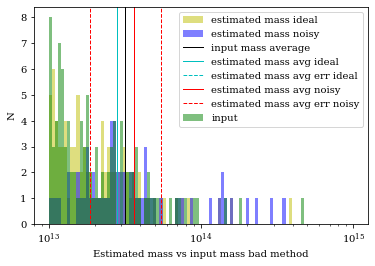

In [26]:
#input estimated masszdistrib
plt.hist(m_est_ideal_singlez, bins=np.logspace(13,15,100), facecolor='y', alpha=0.5, label="estimated mass ideal")
plt.hist(m_est_noisy_singlez, bins=np.logspace(13,15,100), facecolor='b', alpha=0.5, label="estimated mass noisy")
plt.axvline(cluster_data_mass_avg, color='k', linestyle='solid', linewidth=1 , label="input mass average")
plt.axvline(m_est_ideal_singlez_avg, color='c', linestyle='solid', linewidth=1, label="estimated mass avg ideal")
plt.axvline(m_est_ideal_singlez_avg-m_est_ideal_singlez_avg_err, color='c', linestyle='dashed', linewidth=1, label="estimated mass avg err ideal")
plt.axvline(m_est_ideal_singlez_avg+m_est_ideal_singlez_avg_err, color='c', linestyle='dashed', linewidth=1)
plt.axvline(m_est_noisy_singlez_avg, color='r', linestyle='solid', linewidth=1, label="estimated mass avg noisy")
plt.axvline(m_est_noisy_singlez_avg-m_est_noisy_singlez_avg_err, color='r', linestyle='dashed', linewidth=1, label="estimated mass avg err noisy")
plt.axvline(m_est_noisy_singlez_avg+m_est_noisy_singlez_avg_err, color='r', linestyle='dashed', linewidth=1)
plt.hist(cluster_data[:,0],bins=np.logspace(13,15,100), facecolor='g', alpha=0.5 , label="input")
#plt.errorbar(m_est_ideal_singlez_avg,0, xerr=m_est_ideal_singlez_avg_err, fmt="", color="r")
plt.xlabel('Estimated mass vs input mass bad method')
plt.legend(loc="upper right")
plt.gca().set_xscale("log")
plt.ylabel('N')
plt.show()


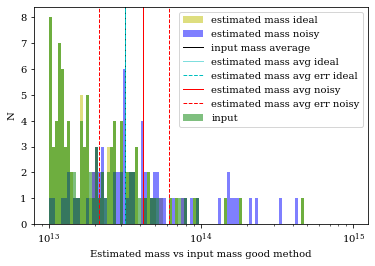

In [27]:
#input estimated masszdistrib
pyrand = np.random.normal(m_est_ideal_zdistrib
                        ,m_est_err_ideal_zdistrib)
#plt.plot(pyrand)
plt.hist(m_est_ideal_zdistrib, bins=np.logspace(13,15,100),  facecolor='y', alpha=0.5, label="estimated mass ideal")
plt.hist(m_est_noisy_zdistrib, bins=np.logspace(13,15,100),  facecolor='b', alpha=0.5, label="estimated mass noisy")
plt.axvline(cluster_data_mass_avg, color='k', linestyle='solid', linewidth=1 , label="input mass average")
plt.axvline(m_est_ideal_zdistrib_avg, color='c',alpha=0.5, linestyle='solid', linewidth=1, label="estimated mass avg ideal")
plt.axvline(m_est_ideal_zdistrib_avg-m_est_ideal_zdistrib_avg_err, color='c', linestyle='dashed', linewidth=1, label="estimated mass avg err ideal")
plt.axvline(m_est_ideal_zdistrib_avg+m_est_ideal_zdistrib_avg_err, color='c', linestyle='dashed', linewidth=1)
plt.axvline(m_est_noisy_zdistrib_avg, color='r', linestyle='solid', linewidth=1, label="estimated mass avg noisy")
plt.axvline(m_est_noisy_zdistrib_avg-m_est_noisy_zdistrib_avg_err, color='r', linestyle='dashed', linewidth=1, label="estimated mass avg err noisy")
plt.axvline(m_est_noisy_zdistrib_avg+m_est_noisy_zdistrib_avg_err, color='r', linestyle='dashed', linewidth=1)
plt.hist(cluster_data[:,0], bins=np.logspace(13,15,100), facecolor='g', alpha=0.5 , label="input")
#plt.errorbar(m_est_ideal_singlez_avg,0, xerr=m_est_ideal_singlez_avg_err, fmt="", color="r")
plt.xlabel('Estimated mass vs input mass good method')
plt.xscale('log')
plt.legend(loc="upper right")
plt.ylabel('N')
plt.show()


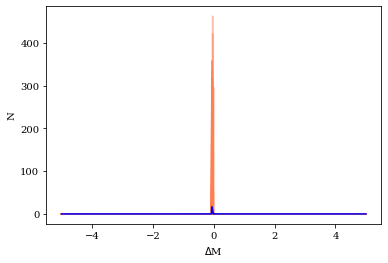

In [28]:
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
from math import log, exp
difference_ideal_singlez = np.log10(m_est_ideal_singlez)-np.log10(cluster_data[:,0])
#print(difference)
std_ideal_singlez = (1/np.log(10))*np.array(m_est_err_ideal_singlez)/np.array(m_est_ideal_singlez)
#print(mean)
#print(std)
x_min=-5
x_max=5

x = np.linspace(x_min, x_max, 1000)
ysum_ideal_singlez = 0

for k in range(num):

    y_ideal_singlez = scipy.stats.norm.pdf(x,difference_ideal_singlez[k],std_ideal_singlez[k])
    #print(y[k])
    #print(mean[k])
    #print(std[k])
    ysum_ideal_singlez = ysum_ideal_singlez + y_ideal_singlez
    
    #plt.plot(x,y, color='coral')

   

    plt.plot(x,y_ideal_singlez, color='coral',alpha=0.5)
#print(ysum)

plt.plot(x,ysum_ideal_singlez/200, color='blue')
plt.xlabel('$\Delta$M')
plt.ylabel('N')

#plt.plot(y,z)

plt.show()
#print(mean)
#print(std)

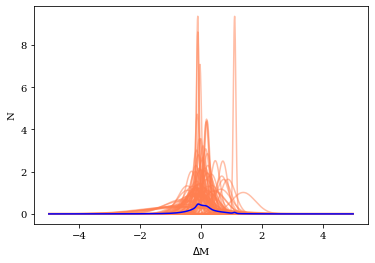

In [29]:
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
from math import log, exp
difference_noisy_singlez = np.log10(m_est_noisy_singlez)-np.log10(cluster_data[:,0])
#print(difference)
std_noisy_singlez = (1/np.log(10))*np.array(m_est_err_noisy_singlez)/np.array(m_est_noisy_singlez)
#print(mean)
#print(std)
x_min=-5
x_max=5

x = np.linspace(x_min, x_max, 1000)
ysum_noisy_singlez = 0

for k in range(num):

    y_noisy_singlez = scipy.stats.norm.pdf(x,difference_noisy_singlez[k],std_noisy_singlez[k])
    #print(y[k])
    #print(mean[k])
    #print(std[k])
    ysum_noisy_singlez = ysum_noisy_singlez + y_noisy_singlez
    
    #plt.plot(x,y, color='coral')

   

    plt.plot(x,y_noisy_singlez, color='coral',alpha=0.5)
#print(ysum)

plt.plot(x,ysum_noisy_singlez/200, color='blue')
plt.xlabel('$\Delta$M')
plt.ylabel('N')

#plt.plot(y,z)

plt.show()
#print(mean)
#print(std)

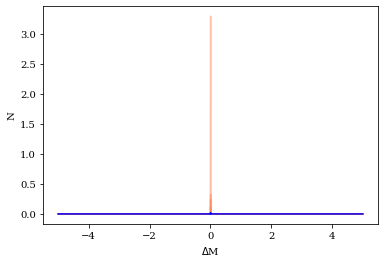

In [30]:
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
from math import log, exp
difference_ideal_zdistrib = np.log10(m_est_ideal_zdistrib)-np.log10(cluster_data[:,0])
#print(difference)
std_ideal_zdistrib = (1/np.log(10))*np.array(m_est_err_ideal_zdistrib)/np.array(m_est_ideal_zdistrib)
#print(mean)
#print(std)
x_min=-5
x_max=5

x = np.linspace(x_min, x_max, 1000)
ysum_ideal_zdistrib = 0

for k in range(num):

    y_ideal_zdistrib = scipy.stats.norm.pdf(x,difference_ideal_zdistrib[k],std_ideal_zdistrib[k])
    #print(y[k])
    #print(mean[k])
    #print(std[k])
    ysum_ideal_zdistrib = ysum_ideal_zdistrib + y_ideal_zdistrib
    
    #plt.plot(x,y, color='coral')

   

    plt.plot(x,y_ideal_zdistrib, color='coral',alpha=0.5)
#print(ysum)

plt.plot(x,ysum_ideal_zdistrib/200, color='blue')
plt.xlabel('$\Delta$M')
plt.ylabel('N')

#plt.plot(y,z)

plt.show()
#print(mean)
#print(std)

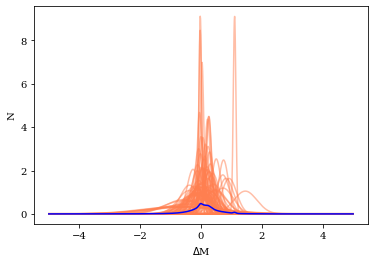

In [31]:
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
from math import log, exp
difference_noisy_zdistrib = np.log10(m_est_noisy_zdistrib)-np.log10(cluster_data[:,0])
#print(difference)
std_noisy_zdistrib = (1/np.log(10))*np.array(m_est_err_noisy_zdistrib)/np.array(m_est_noisy_zdistrib)
#print(mean)
#print(std)
x_min=-5
x_max=5

x = np.linspace(x_min, x_max, 1000)
ysum_noisy_zdistrib = 0

for k in range(num):

    y_noisy_zdistrib = scipy.stats.norm.pdf(x,difference_noisy_zdistrib[k],std_noisy_zdistrib[k])
    ysum_noisy_zdistrib = ysum_noisy_zdistrib + y_noisy_zdistrib
    
    #plt.plot(x,y, color='coral')

   

    plt.plot(x,y_noisy_zdistrib, color='coral',alpha=0.5)
#print(ysum)

plt.plot(x,ysum_noisy_zdistrib/200, color='blue')
plt.xlabel('$\Delta$M')
plt.ylabel('N')

#plt.plot(y,z)

plt.show()
#print(mean)
#print(std)

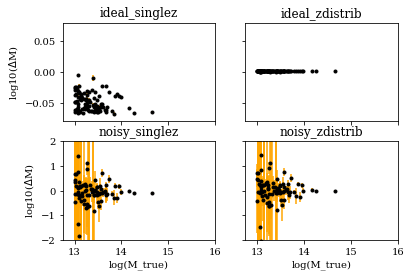

In [32]:
#alle methoden in einem Plot

fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(np.log10(cluster_data[:,0]),difference_ideal_singlez, alpha = 0.5, s=0.1, marker=',')
axs[0, 0].set_title('ideal_singlez')
axs[0, 0].errorbar(np.log10(cluster_data[:,0]), difference_ideal_singlez, yerr=std_ideal_singlez, fmt='.', ecolor = 'orange',c='black')
axs[0, 0].set_xlim([12.75,16])
axs[0, 0].set_ylim([-0.08,0.08])


axs[1, 0].scatter(np.log10(cluster_data[:,0]),difference_noisy_singlez, alpha = 0.5, s=0.1, marker=',')
axs[1, 0].set_title('noisy_singlez')
axs[1, 0].errorbar(np.log10(cluster_data[:,0]), difference_noisy_singlez, yerr=std_noisy_singlez, fmt='.', ecolor = 'orange',c='black')
axs[1, 0].set_xlim([12.75,16])
axs[1, 0].set_ylim([-2,2])

axs[0, 1].scatter(np.log10(cluster_data[:,0]),difference_ideal_zdistrib, alpha = 0.5, s=0.1, marker=',')
axs[0, 1].set_title('ideal_zdistrib')
axs[0, 1].errorbar(np.log10(cluster_data[:,0]), difference_ideal_zdistrib, yerr=std_ideal_zdistrib, fmt='.', ecolor = 'orange',c='black')
axs[0, 1].set_xlim([12.75,16])
axs[0, 1].set_ylim([-0.08,0.08])

axs[1, 1].scatter(np.log10(cluster_data[:,0]),difference_noisy_zdistrib, alpha = 0.5, s=0.1, marker=',')
axs[1, 1].set_title('noisy_zdistrib')
axs[1, 1].errorbar(np.log10(cluster_data[:,0]), difference_noisy_zdistrib, yerr=std_noisy_zdistrib, fmt='.', ecolor = 'orange',c='black')
axs[1, 1].set_xlim([12.75,16])
axs[1, 1].set_ylim([-2,2])


for ax in axs.flat:
    ax.set(xlabel='log(M_true)', ylabel='log10($\Delta$M)')

 #Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

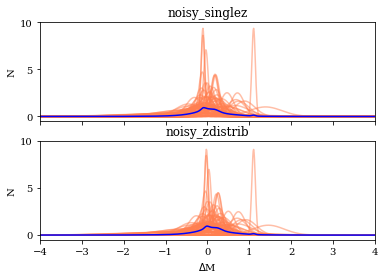

In [33]:
#alle methoden in einem Plot
ysum_ideal_singlez = 0
ysum_noisy_singlez = 0
ysum_ideal_zdistrib = 0
ysum_noisy_zdistrib = 0
fig, axs = plt.subplots(2,1)

for k in range(num):
    y_noisy_singlez = scipy.stats.norm.pdf(x,difference_noisy_singlez[k],std_noisy_singlez[k])
    ysum_noisy_singlez = ysum_noisy_singlez + y_noisy_singlez
    axs[0].plot(x,y_noisy_singlez, color='coral',alpha=0.5)

axs[0].plot(x,ysum_noisy_singlez/100, color='blue')
axs[0].set_title('noisy_singlez')
axs[0].set_xlim([-4,4])
axs[0].set_ylim([-0.5,10])


for k in range(num):
    y_noisy_zdistrib = scipy.stats.norm.pdf(x,difference_noisy_zdistrib[k],std_noisy_zdistrib[k])
    ysum_noisy_zdistrib = ysum_noisy_zdistrib + y_noisy_zdistrib
    axs[1].plot(x,y_noisy_zdistrib, color='coral',alpha=0.5)
    
axs[1].plot(x,ysum_noisy_zdistrib/100, color='blue')
axs[1].set_title('noisy_zdistrib')
axs[1].set_xlim([-4,4])
axs[1].set_ylim([-0.5,10])


for ax in axs.flat:
    ax.set(xlabel='$\Delta$M', ylabel='N')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [34]:
#compute the excess surface density
import clmm.theory as m
mass_Delta = 200
DeltaSigma = []
r3d = []
density_profile_parametrization = 'nfw'
for k in range(num):
    #r3d = np.logspace(-2, 2, 15)
    r3d = np.linspace(-1,4,15)
    cluster_mass = cluster_data[k][0]
    cluster_concentration = cluster_data[k][1]
    z_cl = cluster_data[k][4]
    DeltaSigma.append(m.compute_excess_surface_density(r3d, cluster_mass, cluster_concentration, z_cl, cosmo=cosmo, 
                                              delta_mdef=mass_Delta, 
                                              halo_profile_model=density_profile_parametrization))
print(np.shape(DeltaSigma[0]))

(15,)


/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/pyccl/halos/profiles.py:751: RuntimeWarning: invalid value encountered in log
  return np.log(0.5 * xx) + np.arccosh(1 / xx) / sqx2m1
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/pyccl/halos/profiles.py:751: RuntimeWarning: invalid value encountered in arccosh
  return np.log(0.5 * xx) + np.arccosh(1 / xx) / sqx2m1
/Users/nicomasii/opt/anaconda3/envs/clmm/lib/python3.9/site-packages/pyccl/halos/profiles.py:716: RuntimeWarning: invalid value encountered in arccosh
  return 1 / x2m1 + np.arccosh(1 / xx) / np.fabs(x2m1)**1.5


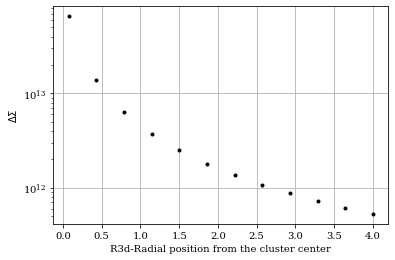

In [35]:
#Plot the excess Surface density against R
# Label für die y-Achse vergeben:
plt.ylabel('$\Delta\Sigma$')
plt.xlabel('R3d-Radial position from the cluster center')
# Einen x-y-Plot erstellen:
plt.plot(r3d, DeltaSigma[0],color='black', linestyle='', marker='.')

# Achsen-Bereiche manuell festlegen
# Syntax: plt.axis([xmin, xmax, ymin, ymax])
#plt.axis([0, 5, 0, 20])
#plt.xscale('log')
plt.yscale('log')
# Ein gepunktetes Diagramm-Gitter einblenden:
plt.grid(True)


# Diagramm anzeigen:
plt.show()

In [36]:



DeltaSigmastack = np.zeros(15)
DeltaSigmaarray = np.array(DeltaSigma)
print(type(DeltaSigmastack))
for k in range(num):
    DeltaSigmastack = DeltaSigmastack + DeltaSigmaarray[k]
print(DeltaSigmastack/num)



<class 'numpy.ndarray'>
[      nan       nan       nan 9.691e+13 2.616e+13 1.297e+13 7.974e+12
 5.483e+12 4.040e+12 3.121e+12 2.495e+12 2.047e+12 1.714e+12 1.460e+12
 1.260e+12]


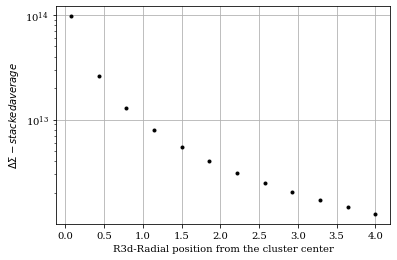

In [37]:
#Plot the excess Surface density against R
# Label für die y-Achse vergeben:
plt.ylabel('$\Delta\Sigma-stacked average$')
plt.xlabel('R3d-Radial position from the cluster center')
# Einen x-y-Plot erstellen:
plt.plot(r3d, DeltaSigmastack/num,color='black', linestyle='', marker='.')

# Achsen-Bereiche manuell festlegen
# Syntax: plt.axis([xmin, xmax, ymin, ymax])
#plt.axis([0, 5, 0, 20])
#plt.xscale('log')
plt.yscale('log')
# Ein gepunktetes Diagramm-Gitter einblenden:
plt.grid(True)


# Diagramm anzeigen:
plt.show()

In [38]:

print(cl_ideal[0].profile['z'])
print(k)
print(cluster_data[0][4])


        z         
------------------
1.3201394372599873
1.3051485005489063
1.2051443443171614
 1.191999753984579
 1.125671034780927
1.2206752451168983
1.2502108824627127
1.2036337558748418
 1.153090546492164
1.1840347649628151
 1.199222944924063
1.1947004808247934
 1.224279593163321
1.2144930407452776
1.1723255810804134
99
0.16156920601514627


In [39]:
#eval sigma_crit from gamma t
#delta_sigma= gamma_t * sigma_crit
import clmm.cosmology.ccl as tt
cosm=tt.CCLCosmology()
Sigmacritideal=[]
Sigmacritnoisy=[]
for k in range(num): 
    Sigmacritideal.append(cosm.eval_sigma_crit(z_src=cl_ideal[k].profile['z'], z_len=cluster_data[k][4]))
    Sigmacritnoisy.append(cosm.eval_sigma_crit(z_src=cl_noisy[k].profile['z'], z_len=cluster_data[k][4]))
#delta sigma from gamma t ideal:
deltasigma_gt_ideal=cl_ideal[0].profile['gt']*Sigmacritideal[0]
#delta sigma from gamma t noisy:
deltasigma_gt_noisy=cl_noisy[0].profile['gt']*Sigmacritnoisy[0]

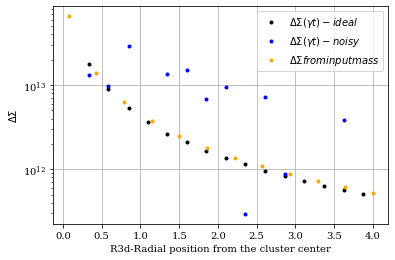

In [40]:
#um zu gucken ob die berechnungen stimmen von den einzelnen deltasigmagt

r3d1 = np.logspace(-1, 4, 15)
r3d1 = cl_ideal[0].profile['radius']
#Plot the excess Surface density against R
# Label für die y-Achse vergeben:
plt.ylabel('$\Delta\Sigma$')
plt.xlabel('R3d-Radial position from the cluster center')
# Einen x-y-Plot erstellen:
plt.plot(r3d1, deltasigma_gt_ideal,color='black', linestyle='', marker='.', label="$\Delta\Sigma(\gamma t)-ideal$")
plt.plot(r3d1, deltasigma_gt_noisy,color='blue', linestyle='', marker='.', label="$\Delta\Sigma(\gamma t)-noisy$")
plt.plot(r3d, DeltaSigma[0],color='orange', linestyle='', marker='.', label="$\Delta\Sigma from input mass$")
# Achsen-Bereiche manuell festlegen
# Syntax: plt.axis([xmin, xmax, ymin, ymax])
#plt.axis([0, 5, 0, 20])
#plt.xscale('log')
plt.yscale('log')
# Ein gepunktetes Diagramm-Gitter einblenden:
plt.grid(True)
plt.legend(loc="upper right")


# Diagramm anzeigen:
plt.show()

In [41]:
import sys
import os
import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
from clmm import Cosmology
from clmm.support import mock_data as mock
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
import numpy as np
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from numpy import random
import chainconsumer
import scipy
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
from scipy.optimize import curve_fit



In [42]:
def texcess_surface_density(single_catalog = None, radial_bin = None, sigma_c = None, radius = None):
    r"""
    Attributes:
    -----------
    
    single_catalog : GalaxyCluster object
    
    radial_bin : liste
        radial bins to evaluate the binned excess surface density
    
    sigma_c : string 
        column name in the single_catalog for the critical surface mass density
        
    Returns:
    --------
    
    ds, r, sum_weights : array, array, array
        the binned excess surface density, the binned radius, the sum of weights w_ls in each radial bin

    """
    #gammat radial bins
    #single_catalog.galcat['R']=radius
    #sigma_c = sigma_crit
    #single_catalog.galcat['et']=gt
    ds = np.zeros(len(radial_bin))
    rad = np.zeros(len(radial_bin))
    sum_weights = np.zeros(len(radial_bin))
    
    radius=single_catalog.profile['radius']
    
    for i, r_bin in enumerate(radial_bin):
        mask = (radius > r_bin[0])*(radius < r_bin[1])
        if any(mask) : 
            w_ls = 1./np.array(sigma_c)[mask]**2
            ds[i] = np.average(np.array(single_catalog.profile['gt'][mask]*sigma_c[mask]), weights = w_ls)
            #
            rad[i] = np.average(radius[mask])
            sum_weights[i] = np.sum( w_ls )
    return ds, rad, sum_weights

In [43]:

from clmm.galaxycluster import GalaxyCluster
new_bins = np.linspace(-2, 4, 15)
radial_bin = [[new_bins[s],new_bins[s+1]] for s in range(len(new_bins)-1)]



names = ['ds_single', 'r_single', 'W_l','c', 'z', 'mass'] #liste
print(type(names))

Stack_file_true = {name : [] for name in names} #dictonary
print(type(Stack_file_true))
 
Stack_file_photoz = {name : [] for name in names} #dictonary

n_catalogs = num
for i in range(n_catalogs):
    ds_single, r_single, sum_weights_single = texcess_surface_density(single_catalog = cl_ideal[i], radial_bin = radial_bin, sigma_c = Sigmacritideal[i]) #tuple unpacking
    #funktion gibt 3 sachen zurück
    data_to_store = [ds_single, r_single, sum_weights_single, cluster_data[i][1], cluster_data[i][4], cluster_data[i][0]]
    #speichern der daten
    for d, name in enumerate(names):
        Stack_file_true[name].append(data_to_store[d])
    
    ds_single, r_single, sum_weights_single = texcess_surface_density(single_catalog = cl_noisy[i], radial_bin = radial_bin, sigma_c = Sigmacritnoisy[i])
    data_to_store = [ds_single, r_single, sum_weights_single, cluster_data[i][1], cluster_data[i][4], cluster_data[i][0]]
    for d, name in enumerate(names):
        Stack_file_photoz[name].append(data_to_store[d])



<class 'list'>
<class 'dict'>


In [44]:
from clmm import utils
meanx,meany,yerr,num_objects,binnumber=utils.compute_radial_averages(Stack_file_photoz['r_single'][0],Stack_file_photoz['ds_single'][0],xbins=bin_edges,error_model='std')
print(yerr)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [45]:

print(Stack_file_true)
print(Stack_file_photoz)
print(type(ds_single))
print(type(cluster_data[i][1]))

{'ds_single': [array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.780e+13,
       7.122e+12, 3.170e+12, 1.873e+12, 1.355e+12, 1.055e+12, 7.779e+11,
       6.396e+11, 5.386e+11]), array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.255e+13,
       9.630e+12, 4.342e+12, 2.593e+12, 1.881e+12, 1.465e+12, 1.088e+12,
       8.910e+11, 7.517e+11]), array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.164e+13,
       8.567e+12, 4.046e+12, 2.377e+12, 1.744e+12, 1.359e+12, 1.010e+12,
       8.287e+11, 6.948e+11]), array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 5.725e+13,
       2.182e+13, 1.085e+13, 6.814e+12, 5.092e+12, 3.720e+12, 2.836e+12,
       2.388e+12, 2.004e+12]), array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.046e+13,
       7.327e+12, 3.302e+12, 1.923e+12, 1.387e+12, 1.074e+12, 7.977e+11,
       6.451e+11, 5.527e+11]), array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.232e+13,
       9.205e+12, 3.927e+12

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


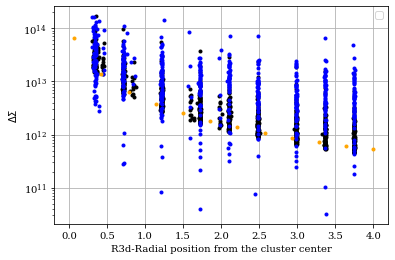

In [46]:
r3d1 = np.logspace(-1, 1, 15)
#Plot the excess Surface density against R
# Label für die y-Achse vergeben:
plt.ylabel('$\Delta\Sigma$')
plt.xlabel('R3d-Radial position from the cluster center')
# Einen x-y-Plot erstellen:
plt.plot(Stack_file_true['r_single'], Stack_file_true['ds_single'],color='black', linestyle='', marker='.')
plt.plot(Stack_file_photoz['r_single'], Stack_file_photoz['ds_single'],color='blue', linestyle='', marker='.')
plt.plot(r3d, DeltaSigma[0],color='orange', linestyle='', marker='.')
# Achsen-Bereiche manuell festlegen
# Syntax: plt.axis([xmin, xmax, ymin, ymax])
#plt.axis([0, 5, 0, 20])
#plt.xscale('log')
plt.yscale('log')
# Ein gepunktetes Diagramm-Gitter einblenden:
plt.grid(True)
plt.legend(loc="upper right")


# Diagramm anzeigen:
plt.show()

In [47]:
#stacked excess surface density profile - true redshift case
print(Stack_file_true['W_l'])
ds_mean_true = np.average(Stack_file_true['ds_single'], weights = Stack_file_true['W_l'], axis = 0)
r_mean_true = np.average(Stack_file_true['r_single'], weights = None, axis = 0)

#stacked excess surface density profile - photoz redshift case
ds_mean_photoz = np.average(Stack_file_photoz['ds_single'], weights = Stack_file_photoz['W_l'], axis = 0)
r_mean_photoz = np.average(Stack_file_photoz['r_single'], weights = None, axis = 0)

[array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 8.804e-32,
       1.736e-31, 1.696e-31, 1.729e-31, 8.578e-32, 1.700e-31, 1.713e-31,
       8.621e-32, 1.711e-31]), array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.332e-31,
       2.670e-31, 2.651e-31, 2.666e-31, 1.318e-31, 2.683e-31, 2.632e-31,
       1.314e-31, 2.680e-31]), array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.391e-31,
       2.691e-31, 2.775e-31, 2.670e-31, 1.326e-31, 2.731e-31, 2.712e-31,
       1.355e-31, 2.716e-31]), array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.550e-31,
       3.400e-31, 3.803e-31, 3.800e-31, 1.611e-31, 3.507e-31, 3.712e-31,
       1.774e-31, 3.787e-31]), array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.636e-31,
       3.525e-31, 3.397e-31, 3.374e-31, 1.689e-31, 3.397e-31, 3.413e-31,
       1.730e-31, 3.462e-31]), array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.771e-31,
       3.674e-31, 3.517e-31, 3.752e-31, 1

ZeroDivisionError: Weights sum to zero, can't be normalized

In [ ]:
sample_covariance_stack_true = np.cov(np.array(Stack_file_true['ds_single']).T)/num
sample_covariance_stack_photoz = np.cov(np.array(Stack_file_photoz['ds_single']).T)/num

In [ ]:
#error propagation for each cluster
for k in range(num):
    ds_single_true_err=Sigmacritideal[k]*np.array(cl_ideal[k].profile['gt_err'])
    ds_single_photoz_err=Sigmacritnoisy[k]*np.array(cl_noisy[k].profile['gt_err'])
print(ds_single_true_err)
print(ds_single_photoz_err)

In [ ]:
r3d1 = np.logspace(-1, 1, 15)
#Plot the excess Surface density against R
# Label für die y-Achse vergeben:
plt.ylabel('$\Delta\Sigma$')
plt.xlabel('R3d-Radial position from the cluster center')
# Einen x-y-Plot erstellen:
#plt.plot(r_mean_true, ds_mean_true,np.sqrt(sample_covariance_stack_true.diagonal()), color='black', linestyle='', marker='.', label="$\Delta\Sigma(\gamma t) stacked average-truez$")
for i in range(num):
    
    plt.plot(Stack_file_true['r_single'][i], Stack_file_true['ds_single'][i], alpha = 0.01, c = 'grey',linestyle='',marker='.',)
    #plt.plot(Stack_file_photoz['r_single'][i], Stack_file_photoz['ds_single'][i], alpha = 0.005, c = 'red', linewidth =20)
plt.plot(Stack_file_true['r_single'][i], Stack_file_true['ds_single'][i], alpha = 1, c = 'grey',linestyle='',marker='.',label="$\Delta\Sigma(\gamma t)single-true$")
    
plt.errorbar(r_mean_true,ds_mean_true,np.sqrt(sample_covariance_stack_true.diagonal()),c='k',linestyle='', 
             marker='.', label="$\Delta\Sigma(\gamma t) stacked average-truez$")
plt.errorbar(r_mean_photoz, ds_mean_photoz,np.sqrt(sample_covariance_stack_photoz.diagonal()), color='blue',linestyle='', marker='.', label="$\Delta\Sigma(\gamma t)stacked average-photoz$")
plt.plot(r3d, DeltaSigma[0],color='orange',linestyle='', marker='.', label="$\Delta\Sigma from input mass$")
# Achsen-Bereiche manuell festlegen
# Syntax: plt.axis([xmin, xmax, ymin, ymax])
#plt.axis([0, 5, 0, 20])
#plt.xscale('log')
plt.yscale('log')
# Ein gepunktetes Diagramm-Gitter einblenden:
plt.grid(True)
plt.legend(loc="upper right")


# Diagramm anzeigen:
plt.show()

In [ ]:
r3d1 = np.logspace(-1, 1, 15)
#Plot the excess Surface density against R
# Label für die y-Achse vergeben:
plt.ylabel('$\Delta\Sigma$')
plt.xlabel('R3d-Radial position from the cluster center')
# Einen x-y-Plot erstellen:
#plt.plot(r_mean_true, ds_mean_true,np.sqrt(sample_covariance_stack_true.diagonal()), color='black', linestyle='', marker='.', label="$\Delta\Sigma(\gamma t) stacked average-truez$")
for i in range(num):
    plt.plot(Stack_file_true['r_single'][i], Stack_file_true['ds_single'][i], alpha = 0.01, c = 'grey',linestyle='',marker='.',)
    #plt.plot(Stack_file_photoz['r_single'][i], Stack_file_photoz['ds_single'][i], alpha = 0.005, c = 'red', linewidth =20)
plt.plot(Stack_file_true['r_single'][i], Stack_file_true['ds_single'][i], alpha = 1, c = 'grey',linestyle='',marker='.',label="$\Delta\Sigma(\gamma t)single-true$")
    
plt.errorbar(r_mean_true,ds_mean_true,np.sqrt(sample_covariance_stack_true.diagonal()),c='k',linestyle='', 
             marker='.', label="$\Delta\Sigma(\gamma t) stacked average-truez$")
plt.errorbar(r_mean_photoz, ds_mean_photoz,np.sqrt(sample_covariance_stack_photoz.diagonal()), color='blue',linestyle='', marker='.', label="$\Delta\Sigma(\gamma t)stacked average-photoz$")
plt.plot(r3d, DeltaSigma[0],color='orange',linestyle='', marker='.', label="$\Delta\Sigma from input mass$")
# Achsen-Bereiche manuell festlegen
# Syntax: plt.axis([xmin, xmax, ymin, ymax])
#plt.axis([0, 5, 0, 20])
#plt.xscale('log')
plt.yscale('log')
# Ein gepunktetes Diagramm-Gitter einblenden:
plt.grid(True)
plt.legend(loc="upper right")


# Diagramm anzeigen:
plt.show()

In [ ]:
r3d1 = np.logspace(-1, 1, 15)
#Plot the excess Surface density against R
# Label für die y-Achse vergeben:
plt.ylabel('$\Delta\Sigma$')
plt.xlabel('R3d-Radial position from the cluster center')
# Einen x-y-Plot erstellen:
#plt.plot(r_mean_true, ds_mean_true,np.sqrt(sample_covariance_stack_true.diagonal()), color='black', linestyle='', marker='.', label="$\Delta\Sigma(\gamma t) stacked average-truez$")
for i in range(num):
    #plt.plot(Stack_file_true['r_single'][i], Stack_file_true['ds_single'][i], alpha = 0.01, c = 'grey')
    plt.plot(Stack_file_photoz['r_single'][i], Stack_file_photoz['ds_single'][i], alpha = 0.01, c = 'red',linestyle='',marker='.')
plt.plot(Stack_file_photoz['r_single'][0], Stack_file_photoz['ds_single'][0], alpha = 1, c = 'red',linestyle='',marker='.',label="$\Delta\Sigma(\gamma t)single-photoz$")
    
plt.errorbar(r_mean_true,ds_mean_true,np.sqrt(sample_covariance_stack_true.diagonal()),c='k',linestyle='', 
             marker='.', label="$\Delta\Sigma(\gamma t) stacked average-truez$")
plt.errorbar(r_mean_photoz, ds_mean_photoz,np.sqrt(sample_covariance_stack_photoz.diagonal()), color='blue', linestyle='', marker='.', label="$\Delta\Sigma(\gamma t)stacked average-photoz$")
plt.plot(r3d, DeltaSigma[0],color='orange', linestyle='', marker='.', label="$\Delta\Sigma from input mass$")
# Achsen-Bereiche manuell festlegen
# Syntax: plt.axis([xmin, xmax, ymin, ymax])
#plt.axis([0, 5, 0, 20])
#plt.xscale('log')
plt.yscale('log')
# Ein gepunktetes Diagramm-Gitter einblenden:
plt.grid(True)
plt.legend(loc="upper right")


# Diagramm anzeigen:
plt.show()

In [ ]:
print(cl_noisy[k].galcat)
help(cl_noisy[k])

In [ ]:
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]

def jackknife(single_catalog = None, N_jk = None):
    
    r"""
    Attributes:
    -----------
    single_catalog : GalaxyCluster object
        GalaxyCluster object of a single cluster 
    N_jk : int
        number of jackknife regions
        
    Returns:
    --------
    cov : array
        Jackknife delete-1 covariance matrix
    
    """
    for k in range(num):
       
        ang, phi = clmm.dataops._compute_lensing_angles_flatsky(cl_noisy[k].ra, cl_noisy[k].dec, cl_noisy[k].galcat['ra'], cl_noisy[k].galcat['dec'])

        cl_noisy[k].galcat['phi'] = np.array(phi)
        #cl_noisy[k].galcat['sigma_c_true'] = cosmo.eval_sigma_crit(cluster_data[4][k], cl_noisy[k].galcat['ztrue'])
    
        
    phi = np.linspace(-np.pi, np.pi, N_jk + 1)
    
    phi_bin = binning(phi)
    
    gt = []
    
    
    mask_list_in = [(phi_[0] < single_catalog.galcat['phi'])*(single_catalog.galcat['phi'] < phi_[1]) for phi_ in phi_bin]
    
    for s, phi_ in enumerate(phi_bin):
        
        mask_in = mask_list_in[s]
        
        mask_out = np.invert(mask_in)
        
        plt.scatter(single_catalog.galcat['ra'][mask_in], single_catalog.galcat['dec'][mask_in], s = 1)
        
        data_cut = single_catalog.galcat[mask_out]
        
        cl_cut_jack = clmm.GalaxyCluster('Stack', single_catalog.ra, single_catalog.dec, single_catalog.z, single_catalog.galcat[mask_out])
        help(cl_cut_jack)
        #radialprofile
        ds, r, sum_weights = excess_surface_density(single_catalog = cl_cut_jack, radial_bin = radial_bin, sigma_c = 'sigma_c')
        
        gt.append(ds)

    gt = np.array(gt)
    
    cov = np.cov(gt.T)*(N_jk-1)**2/N_jk
    
    plt.xlabel('ra')
    plt.ylabel('dec')
    plt.axis('equal')
        
    return cov

In [ ]:
cov_single = jackknife(single_catalog = cl_noisy[0], N_jk = 100)

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# we import some clmm modules

# In[1]:


import sys
import os
import clmm

import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
from clmm import Cosmology
from clmm.support import mock_data as mock
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
import numpy as np
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from numpy import random
import chainconsumer
import scipy
from scipy.interpolate import interp1d
clmm.__version__


# we import `clmm` module's core.

# modules

# In[2]:


import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
from scipy.optimize import curve_fit


# we define `astropy` and `ccl` cosmology object

# In[3]:


mock_cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)


# In[4]:


moo = clmm.Modeling(massdef = 'critical', delta_mdef = 200, halo_profile_model = 'nfw')
moo.set_cosmo(mock_cosmo)


# we define the `Modeling` object `moo` to model the galaxy cluster.

# we now define the type of desired profile : tangential reduced shear of Excess surface density for the stacking procedure by modifying the atribute. We use the method `Type` from the class to select DeltaSigma of reduced tangential shear.

# In[5]:


def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]


# # Estimator of the stacked excess surface density
# 
# - The maximum likelihood estimator of the excess surface density in the radial bin $[R, R + \Delta R[$ is defined by
# 
# $$\widehat{\Delta\Sigma}_+(R) = \frac{1}{\sum\limits_{l,s = 1} w_{ls}}
#      \sum\limits_{l,s= 1}w_{ls}\langle\Sigma_{{\rm crit}}(z_s, z_l)^{-1}\rangle^{-1}\epsilon_+^{s},$$ where $\epsilon_+^{s}$ is the tangential ellipticity of the background galaxy with index $s$ (as source) relative to the dark matter halo position with index $l$ (as lens).
#      
# - The critical surface mass density expresses as $\Sigma_{{\rm crit}}(z_s, z_l) = \frac{c^2}{4 \pi G} \frac{D_A(z_s)}{D_A(z_l) D_A(z_s, z_l)}$, where $D_A(z_l), D_A(z_s)$ are respectively the angular diameter distance to the lens and to the source in physical units, and $D_A(z_s, z_l)$ is the angular diameter distance between the lens and the source.
# 
# 
# - The average $\langle\Sigma_{\rm crit}(z_s,z_l)^{-1}\rangle$ is defined as $\langle\Sigma_{\rm crit}(z_s,z_l)^{-1}\rangle = \int_{z_l + \delta}^{+\infty} d z_s\ p_{\rm photoz,s}(z_s)\ \Sigma_{\rm crit}(z_s,z_l)^{-1}$, where $p_{\rm photoz,s}$ is the photometric probability density function for the background galaxy with index $s$.
# 
# This equation can be re-written as
# 
# $$\widehat{\Delta\Sigma}_+(R) = \frac{1}{\sum\limits_{l = 1} W_{l}}
#      \sum\limits_{l,s= 1}W_{l}\Delta\Sigma_l(R)$$
#      
# where $$\Delta\Sigma_l(R) = \frac{1}{\sum\limits_{s = 1} w_{ls}}
#      \sum\limits_{s= 1}w_{ls}\langle\Sigma_{{\rm crit}}(z_s, z_l)^{-1}\rangle^{-1}\epsilon_+^{s}$$
#      
# and $$W_{l} = \sum\limits_{s= 1}w_{ls}$$
# 
# ### Weights $w_s$
# 
# The quantities $w_{s}$ are the weights that maximise the sigmnal-to-noise ratio of the excess surface density estimator. They downweight the galaxies that are close in redshift to the cluster (where the lensing signal is weak). They include the lack of informations on both redshift and shape reconstruction for each background galaxies. 
# 
# - In the case where there is no error on the shape measurement (for the purpose of cosmoDC2 galaxies), the weight writes $w_{ls} = \langle\Sigma_{\rm crit}(z_s,z_l)^{-1}\rangle^{2}$,
# 
# - In the case of true redshift $z_s$, the PDF reduces to a Dirac function centered at $z_s$, giving the average $\langle\Sigma_{\rm crit}(z_l,z_s)^{-1}\rangle = \Sigma_{\rm crit}(z_l,z_s)^{-1} $ and the weight $w_{s} = \Sigma_{\rm crit}(z_s,z_l)^{-2}$,

# We now define some redshift interval and input mass interval to select GalaxyCluster object in preselected galaxy catalogs from `cosmoDC2`

# # Dark matter halo catalog for the stack

# In[6]:


z_bin = [0.2,0.25]
logm_bin = [14, 14.1] #Solar Mass
logm_bin = np.array(logm_bin)
n_catalogs = 50
ngals = 10000


# we define a set of selected cluster with given true masses ans true redshifts

# In[7]:


#could be function

lower_limit =13
upper_limit =15
nbinhist=n_catalogs
norm = (upper_limit-lower_limit)/nbinhist

M_star = 2.e14
b=4*10**(-5)
numsamp= 10**6 #input
numstep = 10**4

#define x range 1e12-1e15 in num steps
x = np.logspace(lower_limit,upper_limit,numstep)
#define y values from the function 
y = (b*(1/(x/M_star))*np.exp(-(x)/M_star))

#calculate cumulative sum of the y values (numpy)
y_cm = np.cumsum(y)
y_cm = y_cm-min(y_cm)
y_cm = y_cm/np.max(y_cm)

#invert x and y variables (flipping)and interpolate that function 
f = interp1d(y_cm,x , fill_value=(0,1))
#Generate N random numbers uniformly between 0 & 1: u_i~U(0,1)
ynew = np.random.random(numsamp)
#Using the Inverse of the CDF and the values u_i, compute x_i = F^-1(u_i)
x_samp = f(ynew) #return

#plot it to see the result
plt.hist(x_samp, bins=np.logspace(lower_limit,upper_limit,nbinhist),weights=np.repeat(numsamp/sum(y*x),numsamp)/norm)
plt.yscale('log')
plt.xscale('log')
plt.plot(x, y, 'o')
#plt.show()


#use that interpolated function to predict num samples


# In[8]:


cluster_m=np.zeros(n_catalogs)
for k in range(n_catalogs):
    print(k)
    cluster_m[k]=x_samp[k]  #in M_sun
cluster_z = (z_bin[1] - z_bin[0])*np.random.random(n_catalogs) + z_bin[0]
lnc = abs(np.log(4) + 0.1*np.random.randn(n_catalogs))
concentration = 5.72/((1+cluster_z)**0.71)*(cluster_m/10.e14)**(-0.081)


# In[9]:


print(n_catalogs)
print(np.shape(cluster_m))


# In[10]:


plt.scatter(cluster_m, concentration)
plt.xlabel(r'$M_{\rm 200c}$', fontsize = 20)
plt.ylabel(r'$c_{\rm 200c}$', fontsize = 20)


# We add each galaxy catalogs that correponds to binning criteria to the `shear` object through the `Add(self,'file_name')` method.

# In[11]:


shapenoise = 0.005


# In[12]:


def excess_surface_density(single_catalog = None, radial_bin = None, sigma_c = None):
    r"""
    Attributes:
    -----------
    
    single_catalog : GalaxyCluster object
    
    radial_bin : liste
        radial bins to evaluate the binned excess surface density
    
    sigma_c : string 
        column name in the single_catalog for the critical surface mass density
        
    Returns:
    --------
    
    ds, r, sum_weights : array, array, array
        the binned excess surface density, the binned radius, the sum of weights w_ls in each radial bin

    """
    
    ds = np.zeros(len(radial_bin))
    
    r = np.zeros(len(radial_bin))
    
    sum_weights = np.zeros(len(radial_bin))
    
    for i, r_bin in enumerate(radial_bin):

        mask = (single_catalog.galcat['R'] > r_bin[0])*(single_catalog.galcat['R'] < r_bin[1])
        
        w_ls = 1./single_catalog.galcat[sigma_c][mask]**2
        
        ds[i] = np.average(single_catalog.galcat['et'][mask]*single_catalog.galcat[sigma_c][mask], weights = w_ls)
        
        r[i] = np.average(single_catalog.galcat['R'][mask])
        
        sum_weights[i] = np.sum( w_ls )
        
    return ds, r, sum_weights


# ## Generating background galaxy catalogs & estimating individual shear profile

# We use `clmm` to generate `n_catalogs` background galaxy catalogs for each clusters in the sample. We estimate the individual shear profile and store the individual data:
# 
# - `ds_single`, `r_single` the single excess surface density extimated in the radial bins, and the average radius in each radial bins
# - `W_l` the sum of the weight `w_ls` for each lens-source pairs in each radial bins.
# We difine two possible weights `w_ls`, first using true redshifts of sources, second using the photometric redshift pdf for each sources as presented above. In the function `excess_surface_density`, the argument `sigma_c` will be computed using the true redshift of galaxy, of it will be given by $\langle\Sigma_{\rm crit}(z_s,z_l)^{-1}\rangle^{-1}$.

# In[13]:


add_photoz_weights = True


# In[14]:


get_ipython().run_line_magic('time', '')
GalaxyCluster = []

for i in range(n_catalogs):
    
    if i%10 == 0: print(i)
    
    noisy_data_z = mock.generate_galaxy_catalog(cluster_m[i], cluster_z[i], concentration[i], 
                                                cosmo, 
                                                zsrc = 'chang13', 
                                                Delta_SO=200, 
                                                massdef='critical',
                                                halo_profile_model='nfw', 
                                                zsrc_min=cluster_z[i] + 0.1,
                                                zsrc_max=3., 
                                                field_size=10., 
                                                shapenoise=shapenoise, 
                                                photoz_sigma_unscaled=0.05, 
                                                ngals=ngals)
    
    if add_photoz_weights == True:
        
        pzbins_constant = np.linspace(0,3,30)
        
        sigma_crit_1 = 1./mock_cosmo.eval_sigma_crit(cluster_z[i], pzbins_constant)

        photoz_matrix = np.zeros([len(noisy_data_z), len(pzbins_constant)])
        
        r"""
        I added this line since the photoz pdf is not computed on a constant redshift grid. simps integral can be optimized using the same x-axis for multiple integrals.
        =================================================================================================================================================================
        """

        for f in range(len(noisy_data_z['id'])):

            photoz_matrix[f,:] = np.interp(pzbins_constant, noisy_data_z['pzbins'][f], noisy_data_z['pzpdf'][f])
            
        r"""
        =================================================================================================================================================================
        """

        unormed_integral = scipy.integrate.simps(photoz_matrix * sigma_crit_1, x = pzbins_constant, axis = 1)

        norm = scipy.integrate.simps(photoz_matrix, x = pzbins_constant, axis = 1)

        noisy_data_z['sigma_c_photoz'] = (unormed_integral/norm)**(-1)
        
    
    cl = clmm.GalaxyCluster('mock_cluster', 0, 0, cluster_z[i], noisy_data_z)
    
    cl.compute_tangential_and_cross_components(geometry="flat",
                                              shape_component1='e1', shape_component2='e2', 
                                              tan_component='et', cross_component='ex',
                                              add=True, 
                                              is_deltasigma = False, 
                                              cosmo = cosmo)
    
    cl.galcat['R'] = mock_cosmo.eval_da_z1z2(0,cluster_z[i])*cl.galcat['theta']
    
    ang, phi = clmm.dataops._compute_lensing_angles_flatsky(cl.ra, cl.dec, cl.galcat['ra'], cl.galcat['dec'])

    cl.galcat['phi'] = np.array(phi)
    
    cl.galcat['sigma_c_true'] = mock_cosmo.eval_sigma_crit(cluster_z[i], cl.galcat['ztrue'])
    
    GalaxyCluster.append(cl)


# In[15]:


print(cl.galcat['ra'])


# ## Estimating single excess surface density profiles

# # $$\widehat{\Delta\Sigma}_+(R) = \frac{1}{\sum\limits_{l = 1} W_{l}}
#      \sum\limits_{l,s= 1}W_{l}\Delta\Sigma_l(R)$$

# In[16]:


new_bins = np.logspace(np.log10(0.4), np.log10(5), 20)
radial_bin = [[new_bins[s],new_bins[s+1]] for s in range(len(new_bins)-1)]


# In[17]:


names = ['ds_single', 'r_single', 'W_l','c', 'z', 'mass']

Stack_file_true = {name : [] for name in names}

Stack_file_photoz = {name : [] for name in names}

for i in range(n_catalogs):
    
    ds_single, r_single, sum_weights_single = excess_surface_density(single_catalog = GalaxyCluster[i], radial_bin = radial_bin, sigma_c = 'sigma_c_true')
    
    data_to_store = [ds_single, r_single, sum_weights_single, concentration[i], cluster_z[i], cluster_m[i]]
    
    for d, name in enumerate(names):
        
        Stack_file_true[name].append(data_to_store[d])
        
    ds_single, r_single, sum_weights_single = excess_surface_density(single_catalog = GalaxyCluster[i], radial_bin = radial_bin, sigma_c = 'sigma_c_photoz')
    
    data_to_store = [ds_single, r_single, sum_weights_single, concentration[i], cluster_z[i], cluster_m[i]]
    
    for d, name in enumerate(names):
        
        Stack_file_photoz[name].append(data_to_store[d])


# # Stacked excess surface density profile : true z and photoz

# ## Stacked profile

# We estimate the mean excess surface density profile `ds_mean` and the mean radius `r_mean`

# In[18]:


#stacked excess surface density profile - true redshift case
print(Stack_file_true['W_l'])
ds_mean_true = np.average(Stack_file_true['ds_single'], weights = Stack_file_true['W_l'], axis = 0)
r_mean_true = np.average(Stack_file_true['r_single'], weights = None, axis = 0)

#stacked excess surface density profile - photoz redshift case
ds_mean_photoz = np.average(Stack_file_photoz['ds_single'], weights = Stack_file_photoz['W_l'], axis = 0)
r_mean_photoz = np.average(Stack_file_photoz['r_single'], weights = None, axis = 0)


# ## Covariance matrix

# We compute the sample covariance matrix defined as
# $$
#     (\mathbf{C}^{\rm sample})_{i,j} = \frac{1}{N_{\rm cluster} - 1}\sum_{k = 0}^{N_{\rm cluster}}[\Delta\Sigma^k(R_i) - \overline{\Delta\Sigma}(R_i)] [\Delta\Sigma^k(R_j) - \overline{\Delta\Sigma}(R_j)],
# $$
# and $\overline{\Delta\Sigma}(R_i)$ is denoted by
# $$
#     \overline{\Delta\Sigma}(R_i) = \frac{1}{N_{\rm cluster}}\sum_{k = 0}^{N_{\rm boot}} \Delta\Sigma^k(R_i).
# $$

# In[19]:


#covariance matrix
sample_covariance_stack_true = np.cov(np.array(Stack_file_true['ds_single']).T)/n_catalogs
sample_covariance_stack_photoz = np.cov(np.array(Stack_file_photoz['ds_single']).T)/n_catalogs


# # Single cluster : Generating background galaxy catalogs

# To make standard comparison with the stack analysis, we use also consider a single cluster

# In[20]:


noisy_data_z_single = mock.generate_galaxy_catalog(np.mean(cluster_m), np.mean(cluster_z), np.mean(concentration), cosmo, 
                                                zsrc = 'chang13', 
                                                Delta_SO=200, 
                                               massdef='critical',
                                               halo_profile_model='nfw', zsrc_min=np.mean(cluster_z) + 0.1,
                           zsrc_max=3., field_size=10., shapenoise=shapenoise, photoz_sigma_unscaled=0, ngals=ngals)

cl_single = clmm.GalaxyCluster('mock_cluster', 0., 0., np.mean(cluster_z), noisy_data_z_single)

cl_single.compute_tangential_and_cross_components(geometry="flat",
                                                  shape_component1='e1', shape_component2='e2', 
                                                  tan_component='et', cross_component='ex',
                                                  add=True, is_deltasigma = False, cosmo = cosmo)

cl_single.galcat['R'] = mock_cosmo.eval_da_z1z2(0,np.mean(cluster_z))*cl_single.galcat['theta']

ang, phi = clmm.dataops._compute_lensing_angles_flatsky(cl_single.ra, cl_single.dec, cl_single.galcat['ra'], cl_single.galcat['dec'])

cl_single.galcat['phi'] = np.array(phi)

cl_single.galcat['sigma_c'] = mock_cosmo.eval_sigma_crit(np.mean(cluster_z), cl_single.galcat['z'])


# # Single cluster : excess surface density

# ## Excess surface density profile

# In[21]:


#excess surface density profile
ds_single,r_single,sum_weight_single = excess_surface_density(single_catalog = cl_single, radial_bin = radial_bin, sigma_c = 'sigma_c')


# ## Covariance matrix

# We estimate the single excess surface density covariance matrix by the delete-1 Jackknife method : We split the sky area arround the cluster center in $N_{\rm JK}$ regions, and we exclude one region at a time and re-estimate the excess surface density profile:, the covariance writes
# 
# $$
#     (\mathbf{C}^{\rm JK})_{i,j} = \frac{N_{\rm JK} - 1}{N_{\rm JK}}\sum_{k = 0}^{N_{\rm JK}}[\Delta\Sigma^k(R_i) - \overline{\Delta\Sigma}(R_i)] [\Delta\Sigma^k(R_j) - \overline{\Delta\Sigma}(R_j)]
# $$
# with the mean 
# $$
#     \overline{\Delta\Sigma}(R_i) = \frac{1}{N_{\rm JK}}\sum_{k = 0}^{N_{\rm JK}} \Delta\Sigma^k(R_i).
# $$

# In[22]:


def jackknife(single_catalog = None, N_jk = None):
    
    r"""
    Attributes:
    -----------
    single_catalog : GalaxyCluster object
        GalaxyCluster object of a single cluster 
    N_jk : int
        number of jackknife regions
        
    Returns:
    --------
    cov : array
        Jackknife delete-1 covariance matrix
    
    """
    
    phi = np.linspace(-np.pi, np.pi, N_jk + 1)
    
    phi_bin = binning(phi)
    
    gt = []
    
    mask_list_in = [(phi_[0] < single_catalog.galcat['phi'])*(single_catalog.galcat['phi'] < phi_[1]) for phi_ in phi_bin]
    
    for s, phi_ in enumerate(phi_bin):
        
        mask_in = mask_list_in[s]
        
        mask_out = np.invert(mask_in)
        
        plt.scatter(single_catalog.galcat['ra'][mask_in], single_catalog.galcat['dec'][mask_in], s = 1)
        
        data_cut = single_catalog.galcat[mask_out]
        
        cl_cut_jack = clmm.GalaxyCluster('Stack', single_catalog.ra, single_catalog.dec, single_catalog.z, single_catalog.galcat[mask_out])
        
        ds, r, sum_weights = excess_surface_density(single_catalog = cl_cut_jack, radial_bin = radial_bin, sigma_c = 'sigma_c')
        
        gt.append(ds)

    gt = np.array(gt)
    
    cov = np.cov(gt.T)*(N_jk-1)**2/N_jk
    
    plt.xlabel('ra')
    plt.ylabel('dec')
    plt.axis('equal')
        
    return cov


# In[23]:


#Jackknife covariance matrix
cov_single = jackknife(single_catalog = cl_single, N_jk = 100)


# In[24]:


fig, axs = plt.subplots(2,2, figsize = (20,10))
#axs[0,0].imshow(np.corrcoef(cov_ss), vmin = -1,, cmap = 'bwr', origin = 'lower')
min_value = min(sample_covariance_stack_true.flatten())
im = axs[0,0].imshow(cov_single, cmap = 'Reds', origin = 'lower', label = 'single-jackknife')
plt.colorbar(im, ax=axs[0,0])
axs[0,1].errorbar(r_single,ds_single, np.sqrt(cov_single.diagonal()), label = 'single')
moo.set_concentration(concentration.mean())
moo.set_mass(cluster_m.mean())
axs[0,1].plot(r_single,moo.eval_excess_surface_density(r_single, cluster_z.mean()), label = 'fiducial')
axs[0,1].set_ylim(0.3*1e13, 3.5*1e13)

im = axs[1,0].imshow(sample_covariance_stack_true, cmap = 'Reds', origin = 'lower' ,label = 'stack-sample')
plt.colorbar(im, ax=axs[1,0])

plt.figure(figsize = (20,10))
for i in range(n_catalogs):
    axs[1,1].plot(Stack_file_true['r_single'][i], Stack_file_true['ds_single'][i], alpha = 0.01, c = 'grey', linewidth =20)
axs[1,1].errorbar(r_mean_true,ds_mean_true, np.sqrt(sample_covariance_stack_true.diagonal()), linewidth = 3, label = 'stack - true z')
axs[1,1].errorbar(r_mean_photoz,ds_mean_photoz, np.sqrt(sample_covariance_stack_photoz.diagonal()), linewidth = 3,fmt = '.', label = 'stack - photoz')
axs[1,1].set_ylim(0.3*1e13, 3.5*1e13)

axs[0,0].set_title('covariance matrix', fontsize = 20)
axs[0,1].set_title('Excess surface density profile', fontsize = 20)
for i in range(2):
    axs[i,1].set_xlim(min(r_single), max(r_single))
    axs[i,1].set_ylim(0.3*1e13, 3.5*1e13)
    axs[i,1].set_xlabel('R [Mpc]', fontsize = 20)
    axs[i,1].set_ylabel(r'$\Delta\Sigma$', fontsize = 20)
    
for i in range(2):
    for j in range(2):
        axs[i,j].legend(fontsize = 20)


# # Stack VS single excess surface density : Fitting cluster mass and concentration

# We fit the cluster mass and concentration using the `emcee` package 

# In[25]:


def lnL(theta, r, ds, cov, z):
    
    logm, c = theta
    
    if c < 0.01: return -np.inf

    moo.set_mass(10**logm)
    
    moo.set_concentration(c)
    
    y_th = moo.eval_excess_surface_density(r,z)
    
    delta = (y_th - ds)
    
    inv_cov = np.linalg.inv(cov)
    
    lnL_ds = -0.5*np.sum(delta*inv_cov.dot(delta))
    
    return lnL_ds


# In[26]:


import emcee
initial = [np.log10(np.mean(cluster_m)),np.mean(concentration)]
npath = 500
nwalkers = 50
pos = initial + 0.01 * np.random.randn(nwalkers, len(initial))
nwalkers, ndim = pos.shape
sampler_single = emcee.EnsembleSampler(nwalkers, ndim, lnL, args = (r_single, ds_single, cov_single, np.mean(cluster_z)))
print('Single cluster : running...')
sampler_single.run_mcmc(pos, npath, progress=True);


# In[27]:


print('Stack true z : running...')
sampler_stack_true = emcee.EnsembleSampler(nwalkers, ndim, lnL, args = (r_mean_true, ds_mean_true, sample_covariance_stack_true, np.mean(cluster_z)))
sampler_stack_true.run_mcmc(pos, npath, progress=True);


# In[28]:


print('Stack photoz : running...')
sampler_stack_photoz = emcee.EnsembleSampler(nwalkers, ndim, lnL, args = (r_mean_photoz, ds_mean_photoz, sample_covariance_stack_photoz, np.mean(cluster_z)))
sampler_stack_photoz.run_mcmc(pos, npath, progress=True);


# In[29]:


flat_sample_stack_pre_cut = sampler_stack_true.get_chain(discard = 0, thin = 1, flat = True)
flat_sample_single_pre_cut = sampler_single.get_chain(discard = 0, thin = 1, flat = True)
plt.plot(flat_sample_single_pre_cut[:,0])
plt.plot(flat_sample_stack_pre_cut[:,0])
plt.ylabel(r'$\log_{10}(M_{200c})$', fontsize= 20)
plt.figure()
plt.plot(flat_sample_single_pre_cut[:,1])
plt.plot(flat_sample_stack_pre_cut[:,1])
plt.ylabel(r'$c_{200c}$', fontsize= 20)


# In[30]:


discard = 300
thin = 20


# In[31]:


flat_sample_stack_true = sampler_stack_true.get_chain(discard = discard, thin = thin, flat = True)
flat_sample_stack_photoz = sampler_stack_photoz.get_chain(discard = discard, thin = thin, flat = True)


# In[32]:


flat_sample_single = sampler_single.get_chain(discard = discard, thin = thin, flat = True)


# In[33]:


#flat_sample_stack_true.shape, flat_sample_single.shape


# In[34]:


labels = [r'$\log_{10} M_{\rm 200c}$',r'$c_{\rm 200c}$', ]


# In[35]:


import numpy as np
from chainconsumer import ChainConsumer

mean = [np.log10(np.mean(cluster_m)),np.mean(concentration)]
c = ChainConsumer()
c.add_chain(flat_sample_stack_true, parameters=labels, name = 'Stack - true z')
c.add_chain(flat_sample_stack_photoz, parameters=labels, name = 'Stack - photoz')
c.add_chain(flat_sample_single, parameters=labels, name = 'Single')
c.configure (kde = True,colors=['b', 'r','g'], shade=True, shade_alpha=0.2, bar_shade=True, label_font_size=11, sigma2d=False, sigmas = [1, 2], spacing = 0.0, tick_font_size=11, usetex=False)
plot_args = {}
plot_args['truth'] = mean
fig = c.plotter.plot(**plot_args)
fig.set_size_inches(10, 10)


# In[ ]:


import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
from math import log, exp
difference_noisy_singlez = np.log10(flat_sample_stack_pre_cut)-np.log10(cluster_m)
#print(difference)
std_noisy_singlez = (1/np.log(10))*np.array(m_est_err_noisy_singlez)/np.array(m_est_noisy_singlez)
#print(mean)
#print(std)
x_min=-5
x_max=5

x = np.linspace(x_min, x_max, 1000)
ysum_noisy_singlez = 0

for k in range(num):

    y_noisy_singlez = scipy.stats.norm.pdf(x,difference_noisy_singlez[k],std_noisy_singlez[k])
    #print(y[k])
    #print(mean[k])
    #print(std[k])
    ysum_noisy_singlez = ysum_noisy_singlez + y_noisy_singlez
    
    #plt.plot(x,y, color='coral')

   

    plt.plot(x,y_noisy_singlez, color='coral',alpha=0.5)
#print(ysum)

plt.plot(x,ysum_noisy_singlez/200, color='blue')
plt.xlabel('$\Delta$M')
plt.ylabel('N')

#plt.plot(y,z)

plt.show()
#print(mean)
#print(std)